### Overview and Motivation

The goal of this notebook is to place bounds on the phase shift appearing in 2 to 2 scalar scattering amplitudes. The phase shift can be determined by an integral 

$$B (z) \sin \phi (z) = \frac{1}{4 \pi} \int_{- 1}^1 d z_1  \int_0^{2 \pi} d
   \phi_1 B (z_1) B (z_2) e^{i \phi (z_1) - i \phi (z_2)} $$
   
   where we use $z_2 = zz_1 + (1 - z^2)^{1 / 2}  (1 - z_1^2)^{1 / 2} \cos \phi_1$. Here $B(z)$ represents the differential cross section, where $z$ is $\cos \theta$, with $\theta$ the scattering angle. The goal will be to solve this equation for a function $\phi(z)$, the phase shift, assuming that $B(z)$ is given.

##### Difference

In this notebook we look whether it is better to actually predict $\sin \phi$ and $\cos \phi$ separately
We might need to add a loss term to force $\sin^2 \phi + \cos^2 \phi =1$ but that can be studied afterwards

##### Library imports along with setting up the Neptune environment

In [1]:
import os
import neptune.new as neptune
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch import Generator
import math
from collections import OrderedDict
import numpy as np
from itertools import chain

# Set the Neptune Logger variables
NEPTUNE_API_TOKEN = os.environ.get('NEPTUNE_API_TOKEN')
NEPTUNE_PROJECT = os.environ.get('NEPTUNE_ALIAS') + '/2to2scattering'

In [129]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

##### Define the relevant neural networks

In [212]:
class PhiNet(nn.Module):
    def __init__(self, ffnlayers, activation, device='cpu', final_layer='Sigmoid'):
        """
        Initialize the network with the number of FC layers, the activation function, and the device to use
        """
        super(PhiNet, self).__init__()
        
        self.device = device

        if activation=='ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        else:
            raise NotImplemented
        
        if final_layer=='Sigmoid':
            self.final_layer = nn.Sigmoid()
            self.final_l = 'Sigmoid'
        elif final_layer == 'Tanh':
            self.final_layer = nn.Tanh()
            self.final_l = 'Tanh'
        else:
            raise NotImplemented
        
        # Create a list of layers from the parameters given. Add the appropriate activation function
        self.layer_sizes = ffnlayers
        layer_list = []
        
        for i, layer_size in enumerate(self.layer_sizes):
            if i == 0:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(1, layer_size)))
                layer_list.append(('activation_%d' % (i+1), self.activation))
            else:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(self.layer_sizes[i-1], layer_size)))
                layer_list.append(('activation_%d' %(i+1), self.activation))
        
        layer_list.append(('layer_%d' % (len(self.layer_sizes)+1), nn.Linear(self.layer_sizes[-1], 2)))
        
        # The last layer is sigmoid to constrain outputs between 0 and 1 or tanh for [-1,1]
        layer_list.append(('final_layer', self.final_layer))
            
        
        self.model = nn.Sequential(OrderedDict(layer_list))
    
    
    def forward(self, x):
        """
        Network forward pass where the outputs are the cos and the sin
        """
        #x = (x+1)/2 # Normalize the the cosine input variable
        x = self.model(x)
        
        if self.final_l == 'Sigmoid':
            return 2*x - 1
        else:
            return x
    
    
class ModuleNetManual(nn.Module):
    """
    Class for parametrizing the given differential cross section
    """
    def __init__(self, scan_param=None):
        super(ModuleNetManual, self).__init__()
        self.scan_param = scan_param
        
    def forward(self, x):
        """
        Network forward pass is given by a specific function. Can iterate on the overall scale if we want to
        """
        
        denom = self.scan_param if self.scan_param is not None else 1
        return (-torch.pow(x,3) + torch.pow(x,2) + x + 1)/denom
        #return torch.abs(3*x + 1)/denom
        #return torch.pow(x,2)/denom

class PhaseNetSolver():
    """
    Main class for crafting the simulation
    """
    def __init__(self, params_simu, phi_net, mod_net, optimizer, random_generator, scheduler, device='cpu'):
        """
        Initialize the simulation with the networks, the loss function and the optimizer
        """
        
        self.epochs = params_simu['epochs_num']
        self.batch_size = params_simu['batch_size']
        self.eval_points_num = params_simu['integral_points']
        self.method_int = params_simu['method_int']
        self.p_value = params_simu['p_value']
        self.lambda_repulsive = params_simu['lambda_repulsive']
        self.loss_func = params_simu['loss']
        
        
        if isinstance(phi_net, list):
            self.multi_nets = [net.to(device) for net in phi_net]
            self.phi_net = None
            self.multiple_nets = True
        else:
            self.multi_nets = None
            self.phi_net = phi_net.to(device)
            self.multiple_nets = False
        self.mod_net = mod_net.to(device)
        self.device = device
        self.rand_gen = random_generator
        
        self.optimizer = optimizer
        self.scheduler = scheduler
    
    def z2(self, z, z1, phi):
        """
        Compute the z2 parameter (formula in motivation)
        Place the batch size on first dim, z1 on the second and phi on the third
        """
        term1 = z.unsqueeze(dim=0).transpose(0, 1) * (z1.unsqueeze(dim=0))
        term2 = torch.sqrt(1 - torch.square(z)).unsqueeze(dim=0).transpose(0, 1) * torch.sqrt(1 - torch.square(z1)).unsqueeze(dim=0)
        return term1.unsqueeze(dim=2) + term2.unsqueeze(dim=2)*torch.cos(phi.unsqueeze(dim=0)).view(1,1,-1)
    
    def integral_approximator(self, z, method='trapz'):
        """
        Approximate the value of the RHS of the integral equation.
        Compute the grids of z1 and phi points for given z values and integrate over the grids
        """
        
        # Linear partition of the space
        z1_points = torch.linspace(-1,1,steps=self.eval_points_num, device=self.device, requires_grad=False)
        phi_points = torch.linspace(0, 2*math.pi, steps=self.eval_points_num, device=self.device, requires_grad=False)
        dx_z1 = 2/(self.eval_points_num-1)
        dx_phi = 2*math.pi/(self.eval_points_num-1)
        
        grid_points_b = self.mod_net(z1_points).view(1,-1,1) * self.mod_net(self.z2(z, z1_points, phi_points))
        model_cos = self.phi_net(z1_points.view(1,-1,1))[:,:,:1]*self.phi_net(self.z2(z, z1_points, phi_points).unsqueeze(dim=-1))[:,:,:,:1].squeeze()
        model_sin = self.phi_net(z1_points.view(1,-1,1))[:,:,1:]*self.phi_net(self.z2(z, z1_points, phi_points).unsqueeze(dim=-1))[:,:,:,1:].squeeze()
        
        grid_points = grid_points_b * (model_cos + model_sin)
        
        # Simple trapezoid exists in PyTorch
        if method == 'trapz':
            integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
        
        return integral
    
    
    def loss_consistency(self, zsamples):
        """
        Compute a loss enforcing cos^2 + sin^2 = 1
        """
        
        target = torch.ones(zsamples.size(), device=self.device)
        model_input = self.phi_net(zsamples.view(-1,1))[:,0]**2 + self.phi_net(zsamples.view(-1,1))[:,1]**2
        
        # We have different choices of losses. Huber is more stable to outliers.
        if self.loss_func =='Huber':
            loss_square = F.huber_loss(model_input, target, delta=0.1)
        elif self.loss_func == 'MSE':
            loss_square = F.mse_loss(model_input, target)
        else:
            raise NotImplemented
        
        return loss_square
        
    
    def loss_function(self, zsamples):
        """
        Compute a loss based on the average residuals for the integral equation
        """
        
        # For each value of z we estimate the integral equation
        target = self.mod_net(zsamples)*self.phi_net(zsamples.view(-1,1))[:,1]
        model_input = self.integral_approximator(zsamples, method=self.method_int)
            
        # We have different choices of losses. Huber is more stable to outliers.
        if self.loss_func =='Huber':
            loss_out = F.huber_loss(model_input, target, delta=0.1)
        elif self.loss_func == 'MSE':
            loss_out = F.mse_loss(model_input, target)
        else:
            raise NotImplemented
        
        return loss_out + self.loss_consistency(zsamples)
    
    def multi_loss_function(self, zsamples, logger=None):
        
        if not self.multiple_nets:
            raise NotImplemented
        
        total_loss = 0
        for i, net in enumerate(self.multi_nets):
            self.phi_net = net
            individual_loss = self.loss_function(zsamples)
            logger['metrics/solution_loss_{}'.format(i)].log(individual_loss)
            total_loss = total_loss + individual_loss
        
        return total_loss
    
    def dual_loss(self, zsamples):
             
        if not self.multiple_nets and len(self.multi_nets)!=2:
            raise NotImplemented
        target = self.multi_nets[0](zsamples.view(-1,1))
        model_input = self.multi_nets[1](zsamples.view(-1,1))
        
        # Maybe MSE makes more sense here since we are just comparing functions in the first place
        loss_out = torch.pow(F.mse_loss(model_input, target), -self.p_value)
        
        return loss_out
    
    def dual_loss_ambiguity(self, zsamples):
             
        if not self.multiple_nets and len(self.multi_nets)!=2:
            raise NotImplemented
        
        target = self.multi_nets[0](zsamples.view(-1,1))
        model_input1 = self.multi_nets[1](zsamples.view(-1,1))
        
        model_input2 = torch.transpose(torch.stack((-model_input1[:,0], model_input1[:,1])),0,1)
        
        # Maybe MSE makes more sense here since we are just comparing functions in the first place
        loss_out1 = torch.pow(F.mse_loss(model_input1, target), -self.p_value)
        loss_out2 = torch.pow(F.mse_loss(model_input2, target), -self.p_value)
        
        return loss_out1 + loss_out2
    
    def complete_loss(self, zsamples, dual_active, logger=None):
        
        if not self.multiple_nets:
            return self.loss_function(zsamples)
        else:
            if len(self.multi_nets)!=2:
                raise NotImplemented
            if dual_active:
                repulsive_loss = self.dual_loss_ambiguity(zsamples)
            else: 
                repulsive_loss = 0.0
            logger['metrics/repulsive_loss'].log(repulsive_loss)
                
            return self.multi_loss_function(zsamples, logger=logger) + self.lambda_repulsive * repulsive_loss
    
    def point_loss(self, zsamples):
        """
        If we want to know the residuals at each given z point. This is useful for evaluation purposes
        """
        target = self.mod_net(zsamples)*self.phi_net(zsamples.view(-1,1))[:,1]
        model_input = self.integral_approximator(zsamples)
        
        target2 = torch.ones(zsamples.size(), device=self.device)
        model_input2 = self.phi_net(zsamples.view(-1,1))[:,0]**2 + self.phi_net(zsamples.view(-1,1))[:,1]**2
      
        return torch.square(model_input - target) + torch.square(model_input2 - target2)
        
    def train(self, neptune_run):
        """
        Main training loop. 
        Each epoch is a single optimization step over a unique batch.
        A batch is composed of a number of randomly selected z points between -1 and 1
        """
        
        for epoch_num in range(self.epochs):
            
            dual_active = False if epoch_num < 0.1*self.epochs or epoch_num > 0.4*self.epochs else True
            
            # Set the network in train mode
            if self.multiple_nets:
                for net in self.multi_nets:
                    net.train()
            else:
                self.phi_net.train()
            
            zpoints = torch.rand(self.batch_size, requires_grad=False, generator=self.rand_gen, device='cpu').to(self.device)*2 - 1
            
            # Zero the grads, get the loss and backpropagate
            
            if type(self.optimizer).__name__ == 'LBFGS':
                
                loss = self.complete_loss(zpoints, dual_active, logger=neptune_run)
                
                def closure():
                    if torch.is_grad_enabled():
                        self.optimizer.zero_grad()
                    loss_comp = self.complete_loss(zpoints, dual_active, logger=neptune_run)
                    if loss_comp.requires_grad:
                        loss_comp.backward()
                    return loss_comp
                
                neptune_run['metrics/learning_rate'].log(self.optimizer.param_groups[0]["lr"])
                self.optimizer.step(closure)
                   
            else:
                self.optimizer.zero_grad()
                a =  torch.cuda.memory_allocated(device)
                loss = self.complete_loss(zpoints, dual_active, logger=neptune_run)
                b = torch.cuda.memory_allocated(device)
                loss.backward()
                neptune_run['metrics/learning_rate'].log(self.optimizer.param_groups[0]["lr"])
                self.optimizer.step()
                
            if self.scheduler is not None:
                self.scheduler.step()
            neptune_run['metrics/train_loss'].log(loss)
            
            if epoch_num % 20 == 0:
                print('Train Epoch: {} ; tLoss: {:.6f}'.format(epoch_num, loss.item()))

def scheduler_rate(step, factor, size_param, warmup):
    """
    For the Learning Rate scheduler we implement a warmup start, followed by a square root decay
    """
    if step == 0:
        step = 1
    return factor * size_param**(-0.5) * min(step**(-0.5), step*warmup ** (-1.5))

##### Define the training run

In [213]:
from torchinfo import summary

def train_run(parameters, device, run_neptune, module_net=None, seed_num=42, optim_name='Adam'):
    """
    Function to call for launching the training run
    """
    # Fix for the generator : For reproducibility between cpu and MPS
    random_gen_cpu = Generator(device='cpu')
    random_gen_cpu.manual_seed(seed_num)
    torch.manual_seed(seed_num)   
    torch.cuda.manual_seed(seed_num)
    
    num_phi_nets = parameters['num_nets']
    
    # Define and register the networks
    if num_phi_nets>1:
        phinn = [PhiNet(parameters['layer_list'], parameters['activation'], device=device, final_layer=parameters['final_layer']) for i in range(num_phi_nets)]
        phidisp = phinn[0]
    else:
        phinn = PhiNet(parameters['layer_list'], parameters['activation'], device=device, final_layer=parameters['final_layer'])
        phidisp = phinn
    

    run_neptune["config/phimodel"] = type(phidisp).__name__
    with open(f"model_arch.txt", "w") as f:
        f.write(str(summary(phidisp, verbose=0, col_width=16, device=device)))
        f.write(str(phidisp))
    print(str(phidisp))
    
    if module_net is None:
        modnn = ModuleNetManual(scan_param=parameters['scan_param'])
    else:
        modnn = module_net
    run_neptune["config/modmodel"] = type(modnn).__name__
    
    run_neptune["model_arch"].upload("model_arch.txt")
    
    # Define and register the optimizer and scheduler
    if optim_name == 'Adam':
        if num_phi_nets>1:
            optimizer = torch.optim.Adam(chain.from_iterable([phinet.parameters() for phinet in phinn]), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']))
        else:
            optimizer = torch.optim.Adam(phinn.parameters(), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']))
    elif optim_name == 'LBFGS':
        if num_phi_nets>1:
            optimizer = torch.optim.LBFGS(chain.from_iterable([phinet.parameters() for phinet in phinn]), lr=parameters['learning_rate'], max_iter=4)
        else:
            optimizer = torch.optim.LBFGS(phinn.parameters(), lr=parameters['learning_rate'], max_iter=4)
            
    run_neptune["config/optimizer"] = type(optimizer).__name__
    
    
    if parameters['lr_scheduler']:
        lr_scheduler = LambdaLR(optimizer=optimizer, lr_lambda=lambda step: scheduler_rate(step, 1/parameters['learning_rate'], 2048, 750))
    else:
        lr_scheduler = None
    
    # Create the simulation, train it and return the trained result
    netsolver = PhaseNetSolver(parameters, phinn, modnn, optimizer, random_gen_cpu, lr_scheduler, device=device)
    netsolver.train(run_neptune)

    return netsolver

##### Define the evaluation run

In [214]:
def eval_run(trained_solver, params, device, neptune_run, steps_eval=100, num=None):
    """
    At evaluation we verify if the integral equation is satisfied. 
    For this we take a larger sample of z points
    """
    
    str_add = '_' + str(num) if num is not None else ''
    
    # Make sure we are in evaluation mode
    trained_solver.phi_net.eval()
    with torch.no_grad(): 
        
        # Create the evaluation points and compute the phase at those points
        zpointstest = torch.linspace(-1,1,steps=steps_eval, device=device)
        results = trained_solver.phi_net(zpointstest.view(-1,1))
        phires = torch.atan2(results[:,1],results[:,0]).cpu().numpy()
        sinphires = results[:,1].cpu().numpy()
        
        # Also log the final loss values. Including the loss at individual z values
        trained_solver.scaled_loss = True
        eval_loss_scaled = trained_solver.loss_function(zpointstest)
        neptune_run['metrics/eval_loss_scaled' + str_add].log(eval_loss_scaled)
        eval_point_loss_scaled = trained_solver.point_loss(zpointstest)
        
        trained_solver.scaled_loss = False
        eval_loss_base = trained_solver.loss_function(zpointstest)
        neptune_run['metrics/eval_loss_base' + str_add].log(eval_loss_base)
        eval_point_loss_non_scaled = trained_solver.point_loss(zpointstest)
    
    return zpointstest, phires, sinphires, eval_point_loss_scaled, eval_point_loss_non_scaled

##### Check the value of the $\sin(\mu)$ parameter

In [215]:
def sin_mu_integral(params, device, trained_solver, zpoints):
    """
    Helper function to compute the sin(\mu) variable defined in the motivation.
    This compute the relevant integral involving the differential cross section
    """
    z1_points = torch.linspace(-1,1,steps=params['integral_points'], device=device)
    phi_points = torch.linspace(0, 2*math.pi, steps=params['integral_points'], device=device)
    dx_z1 = 2/(params['integral_points']-1)
    dx_phi = 2*math.pi/(params['integral_points']-1)
        
    grid_points = trained_solver.mod_net(z1_points).view(1,-1,1)*trained_solver.mod_net(netsolver.z2(zpoints, z1_points, phi_points))
        
    integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
        
    return integral/trained_solver.mod_net(zpoints)
   

##### Define the plotting routines

In [216]:
import matplotlib.pyplot as plt
from neptune.new.types import File

def plot_phase(zpoints, phipoints, neptune_run):

    fig = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),phipoints, 'b-', linewidth = 2)       
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('$\phi(z)$ prediction', fontsize = 15)
    plt.xlim([-1,1])
    plt.show()

    neptune_run[f'evaluation/phase_prediction'].upload(File.as_image(fig))
    plt.close(fig)
    
def plot_phases(zpoints, phipoints_list, neptune_run):

    fig = plt.figure(figsize=(14, 10))
    
    for phipoints in phipoints_list:
        plt.plot(zpoints.cpu(),phipoints, '-', linewidth = 2)       
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('$\phi(z)$ prediction', fontsize = 15)
    plt.legend(['Network {}'.format(i+1) for i in range(len(phipoints_list))])
    plt.xlim([-1,1])
    plt.show()

    neptune_run[f'evaluation/phase_prediction'].upload(File.as_image(fig))
    plt.close(fig)
    
    
def plot_point_loss(zpoints, point_loss_data_s, point_loss_data_no_s, neptune_run):

    fig = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(), np.log10(point_loss_data_s.cpu()), 'b-', linewidth = 2)  
    plt.plot(zpoints.cpu(), np.log10(point_loss_data_no_s.cpu()), 'g-', linewidth = 2)  
    plt.xlabel('$z$')
    plt.ylabel('$\log_{10}||\mathcal{L}(z)||_2$')    
    plt.title('Point loss evaluation', fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['Normalized loss at each point', 'Base loss'])
    plt.show()

    neptune_run[f'evaluation/point_loss_evaluation'].upload(File.as_image(fig))
    plt.close(fig)
    

def plot_sin_mu(zpoints, integralpoints, tags_run):

    sinmu = max(integralpoints.cpu())

    fig2 = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.title('Differential cross section categorization: B(z) = {}'.format(tags_run['constant function']), fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()
    
def plot_summary(zpoints, phipoints, sinphipoints, integralpoints, neptune_run, tags_run):
    
    sinmu = max(integralpoints.cpu())
    
    fig3 = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),phipoints, 'b-', linewidth = 2)       
    plt.plot(zpoints.cpu(),sinphipoints, 'b--', linewidth = 2)       
    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.title('Differential cross section categorization: B(z) = {}'.format(tags_run['constant function']), fontsize = 15)
    plt.xlim([-1,1])
    #plt.ylim([-3.14,1])
    plt.legend(['$\phi(z)$', '$\sin \phi(z)$','$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()

    neptune_run[f'evaluation/overview'].upload(File.as_image(fig3))
    plt.close(fig3)

##### Test Run

In [227]:
# Start the Neptune logger run
run = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_quadtest")

params = {'batch_size': 64,
         'epochs_num': 2500,
         'learning_rate': 0.001,
         #'learning_rate': 0.0003,
         'lr_scheduler': False, 
         'beta1' : 0.85,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'layer_list': [64, 64, 64, 64],
         'final_layer': 'Tanh',
         'loss': 'MSE',
         'scan_param': 3,
         'num_nets' : 1,
         'p_value': None,
         'lambda_repulsive': 0.0}

tags = {'constant function': '(-z^3+z^2+z+1)/2', 'optimizer': 'Adam', 'Mode': 'Constant param', 'Huber': '0.1'}
run["sys/tags"].add(list(tags.values()))

run['parameters'] = params

https://app.neptune.ai/zulap/2to2scattering/e/TOS-779
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [228]:
netsolver = train_run(params, device, run, seed_num=42)

PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=2, bias=True)
    (final_layer): Tanh()
  )
)
Train Epoch: 0 ; tLoss: 0.979477
Train Epoch: 20 ; tLoss: 0.250343
Train Epoch: 40 ; tLoss: 0.035838
Train Epoch: 60 ; tLoss: 0.006463
Train Epoch: 80 ; tLoss: 0.003470
Train Epoch: 100 ; tLoss: 0.003772
Train Epoch: 120 ; tLoss: 0.003049
Train Epoch: 140 ; tLoss: 0.002138
Train Epoch: 160 ; tLoss: 0.002919
Train Epoch: 180 ; tLoss: 0.002002
Train Epoch: 200 ; tLoss: 0.002025
Train Epoch: 220 ; tLoss: 0.001781
Train Epoch: 240 ; tLoss: 0.001384
Train

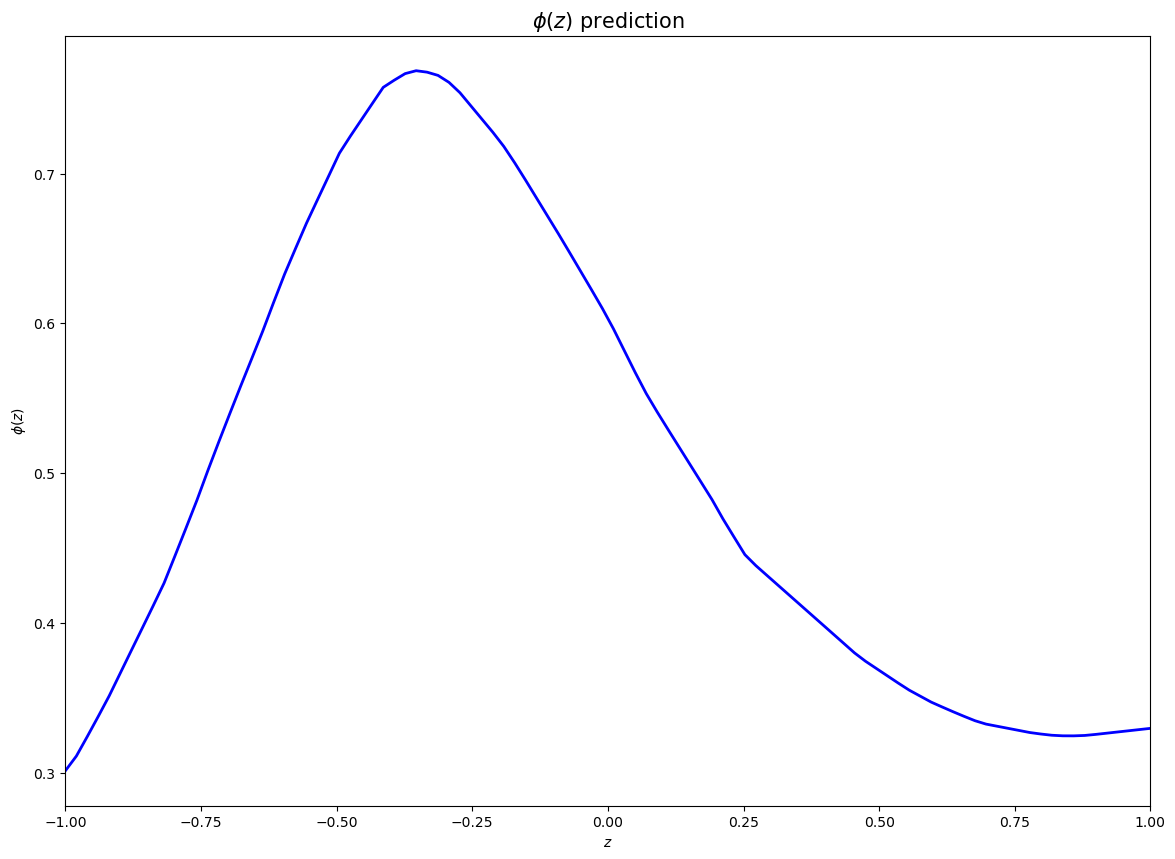

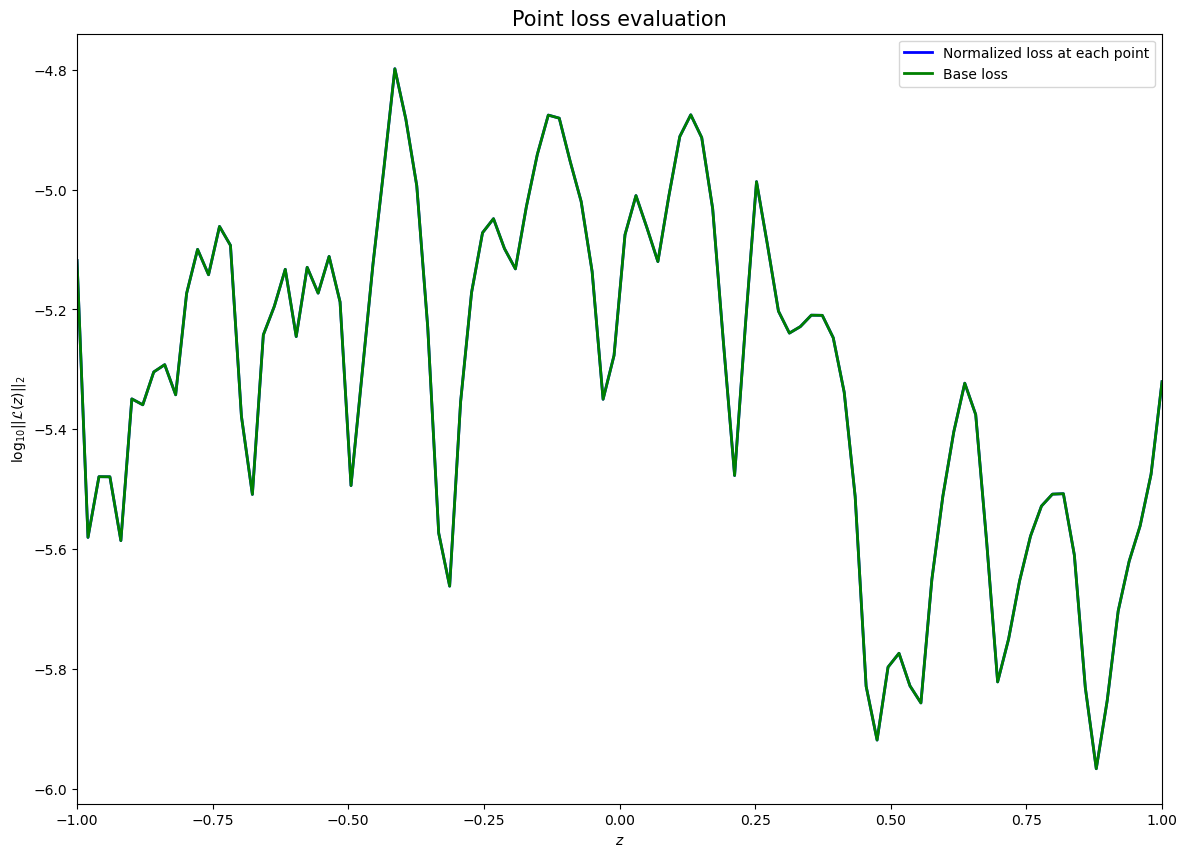

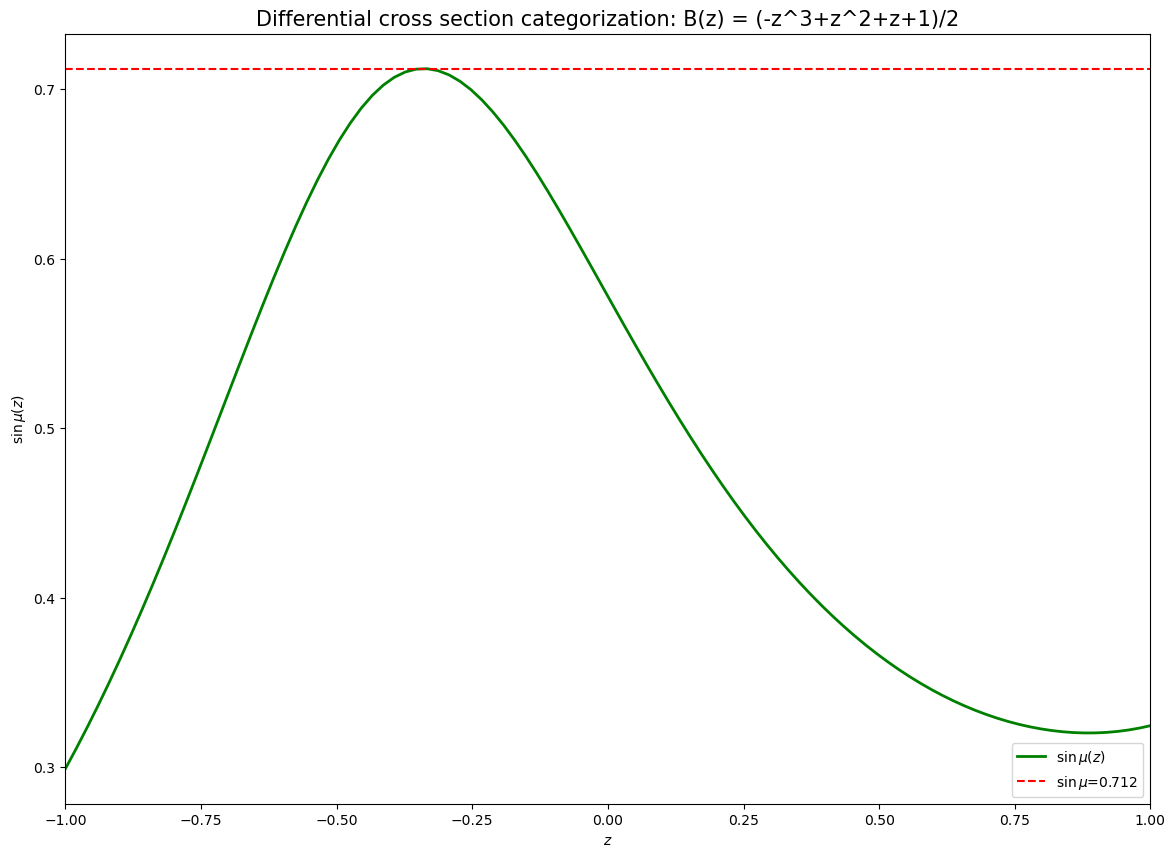

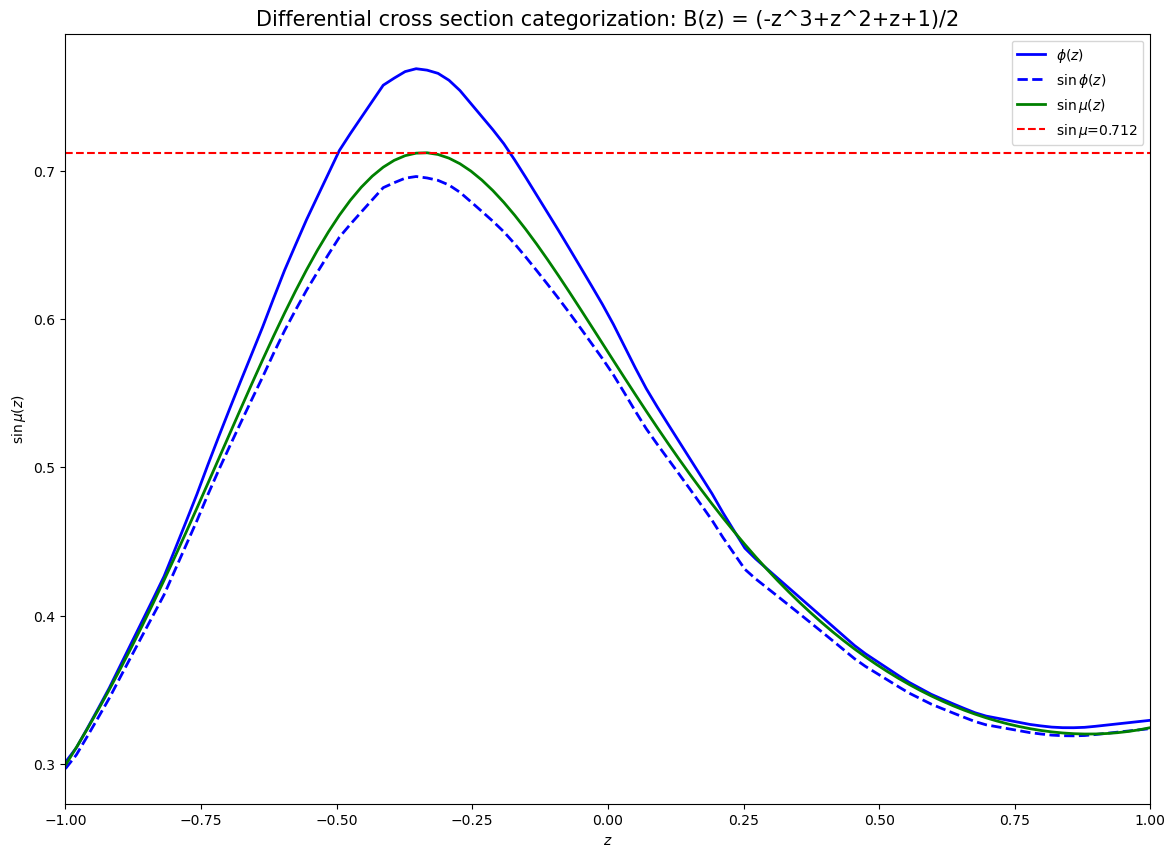

In [229]:
zpointseval, phieval, sinphieval, eval_pt_loss_s, eval_pt_loss_no_s = eval_run(netsolver, params, device, run)

plot_phase(zpointseval, phieval, run)
plot_point_loss(zpointseval, eval_pt_loss_s, eval_pt_loss_no_s, run)

integralz = sin_mu_integral(params, device, netsolver, zpointseval)
plot_sin_mu(zpointseval, integralz, tags)

plot_summary(zpointseval, phieval, sinphieval, integralz, run, tags)

In [230]:
# Make sure to kill the Neptune logger run
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 118 operations to synchronize with Neptune. Do not kill this process.
All 118 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-779


In [240]:
netsolver.phi_net(zpointseval.view(-1,1))[:,0]**2 + netsolver.phi_net(zpointseval.view(-1,1))[:,1]**2

tensor([1.0025, 1.0028, 1.0034, 1.0042, 1.0050, 1.0049, 1.0034, 1.0020, 1.0007,
        0.9993, 0.9976, 0.9959, 0.9943, 0.9925, 0.9907, 0.9895, 0.9889, 0.9889,
        0.9890, 0.9894, 0.9897, 0.9905, 0.9952, 0.9979, 0.9969, 0.9936, 0.9942,
        0.9893, 0.9943, 0.9941, 0.9965, 0.9966, 0.9965, 0.9958, 0.9950, 0.9940,
        0.9934, 0.9942, 0.9948, 0.9949, 0.9947, 0.9942, 0.9939, 0.9943, 0.9946,
        0.9949, 0.9952, 0.9956, 0.9959, 0.9962, 0.9965, 0.9970, 0.9987, 1.0004,
        1.0021, 1.0038, 1.0054, 1.0071, 1.0076, 1.0011, 0.9904, 0.8356, 0.9331,
        0.9916, 0.9938, 0.9953, 0.9966, 0.9975, 0.9981, 0.9983, 0.9980, 0.9973,
        0.9971, 0.9978, 1.0010, 1.0031, 1.0042, 1.0045, 1.0039, 1.0027, 1.0009,
        0.9986, 0.9960, 0.9939, 0.9959, 0.9984, 1.0001, 1.0009, 1.0007, 1.0005,
        1.0002, 0.9992, 0.9983, 0.9974, 0.9965, 0.9956, 0.9951, 0.9949, 0.9947,
        0.9944], device='mps:0', grad_fn=<AddBackward0>)

##### Crichton Ambiguity

In [232]:
class ModuleNetCrichton(nn.Module):
    """
    Class for parametrizing the given differential cross section
    """
    def __init__(self, scale_param=1):
        super(ModuleNetCrichton, self).__init__()
        self.scale_param = scale_param
        
    def forward(self, x):
        """
        Network forward pass is given by a specific function. Can iterate on the overall scale if we want to
        """
        return torch.sqrt(1.38065 + 3.1118 *x - 1.60815*torch.pow(x,2) - 4.731*torch.pow(x,3) + 6.58* torch.pow(x,4))/self.scale_param # Crichton example

In [233]:
import matplotlib.pyplot as plt
from neptune.new.types import File

def crichton_solutions(zpoints):
    z = zpoints.cpu()
    sol1 = torch.angle((5/2)*np.exp(1j*math.pi/9)*(3*torch.pow(z,2)-1)*np.sin(math.pi/9)-np.exp(-7*1j*math.pi/54)*np.sin(7*math.pi/54)-3*np.exp(-869*1j*math.pi/3600)*z*np.sin(869*math.pi/3600))
    sol1 = math.pi - sol1 - 2*math.pi*torch.heaviside(-sol1, torch.tensor(0.0)) + 2*math.pi*torch.heaviside(sol1-2*math.pi, torch.tensor(0.0))
    sol2 = math.pi - torch.angle((5/2)*np.exp(1j*math.pi/9)*(3*torch.pow(z,2)-1)*np.sin(math.pi/9)+np.exp(659*1j*math.pi/1200)*np.cos(59*math.pi/1200)-3*np.exp(-59*1j*math.pi/400)*z*np.sin(59*math.pi/400))
    
    return sol1, sol2

def plot_point_loss_crichton(zpoints, point_loss_data_ses, point_loss_data_noses, neptune_run):

    fig = plt.figure(figsize=(14, 10))
    
    for point_loss_data_s in point_loss_data_ses:
        plt.plot(zpoints.cpu(), np.log10(point_loss_data_s.cpu()), '-', linewidth = 2)  
    
    plt.gca().set_prop_cycle(None)
    for point_loss_data_nos in point_loss_data_noses:
        plt.plot(zpoints.cpu(), np.log10(point_loss_data_nos.cpu()), '--', linewidth = 2)  
    plt.xlabel('$z$')
    plt.ylabel('$\log_{10} ||\mathcal{L}(z)||_2$')    
    plt.title('Point loss evaluation', fontsize = 15)
    plt.xlim([-1,1])
    legendstr = ['Network {} : Normalized point loss'.format(i+1) for i in range(len(point_loss_data_ses))] + ['Network {} : Base point loss'.format(i+1) for i in range(len(point_loss_data_noses))]
    plt.legend(legendstr)
    plt.show()

    neptune_run[f'evaluation/point_loss_evaluation'].upload(File.as_image(fig))
    plt.close(fig)
    
    
def plot_summary_crichton(zpoints, phipoints_list, neptune_run):
    
    
    fig3 = plt.figure(figsize=(14, 10))
    
    sol1, sol2 = crichton_solutions(zpoints)
    
    for phipoints in phipoints_list:
        plt.plot(zpoints.cpu(),phipoints, '--', linewidth = 2)   
    plt.plot(zpoints.cpu(),sol1, 'g', linewidth = 2)   
    plt.plot(zpoints.cpu(),sol2, 'k', linewidth = 2)   
    
     
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('Differential cross section categorization: B(z) : Crichton', fontsize = 15)
    plt.xlim([-1,1])
    legend_nets = ['$\phi(z)$ network {}'.format(i+1) for i in range(len(phipoints_list))]
    plt.legend(legend_nets + ['$\phi_1(z)$ exact', '$\phi_2(z)$ exact'])
    plt.show()

    neptune_run[f'evaluation/overview'].upload(File.as_image(fig3))
    plt.close(fig3)

In [250]:
# Start the Neptune logger run
run = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_testc")

params = {'batch_size': 64,
         'epochs_num': 2500,
         'learning_rate': 0.001,
         'lr_scheduler': False, 
         'beta1' : 0.85,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'fund_dom': False,
         #'layer_list': [64, 128, 128, 64],
         #'layer_list': [64, 64, 64, 64, 64],
         #'layer_list': [128, 256, 256, 128, 64],
         'layer_list' : [64,64, 64, 64],
         'final_layer': 'Tanh',
         'loss': 'MSE',
         'scaled_loss': False,
         'scan_param': None,
         'bound_phi': math.pi,
         'num_nets': 2,
         'p_value': 1,
         'lambda_repulsive': 0.0}

tags = {'constant function': 'Crichton', 'optimizer': 'Adam', 'Mode': 'Constant param', 'Huber': '0.1'}
run["sys/tags"].add(list(tags.values()))

run['parameters'] = params

https://app.neptune.ai/zulap/2to2scattering/e/TOS-795
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=2, bias=True)
    (final_layer): Tanh()
  )
)
Train Epoch: 0 ; tLoss: 1.980783
Train Epoch: 20 ; tLoss: 0.935819
Train Epoch: 40 ; tLoss: 0.584272
Train Epoch: 60 ; tLoss: 0.514048
Train Epoch: 80 ; tLoss: 0.411278
Train Epoch: 100 ; tLoss: 0.453705
Train Epoch: 120 ; tLoss: 0.426470
Train Epoch: 140 ; tLoss: 0.306912
Train Epoch: 160 ; tLoss: 0.219393
Train Epoch: 180 ; tLoss: 0.035967
Train Epoch: 200 ; tLoss: 0.032032
Train Epoch: 220 ; tLoss: 0.028289
Train Epoch: 240 ; tLoss: 0.028178
Train

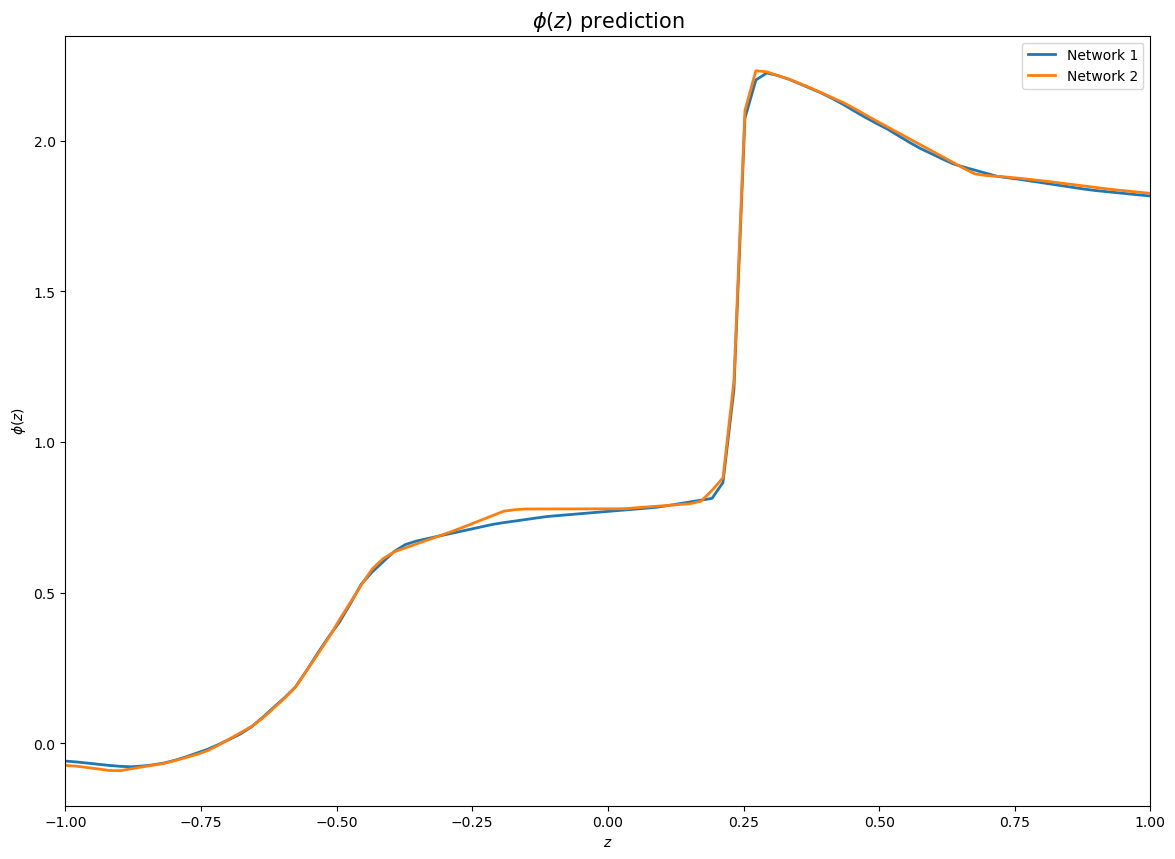

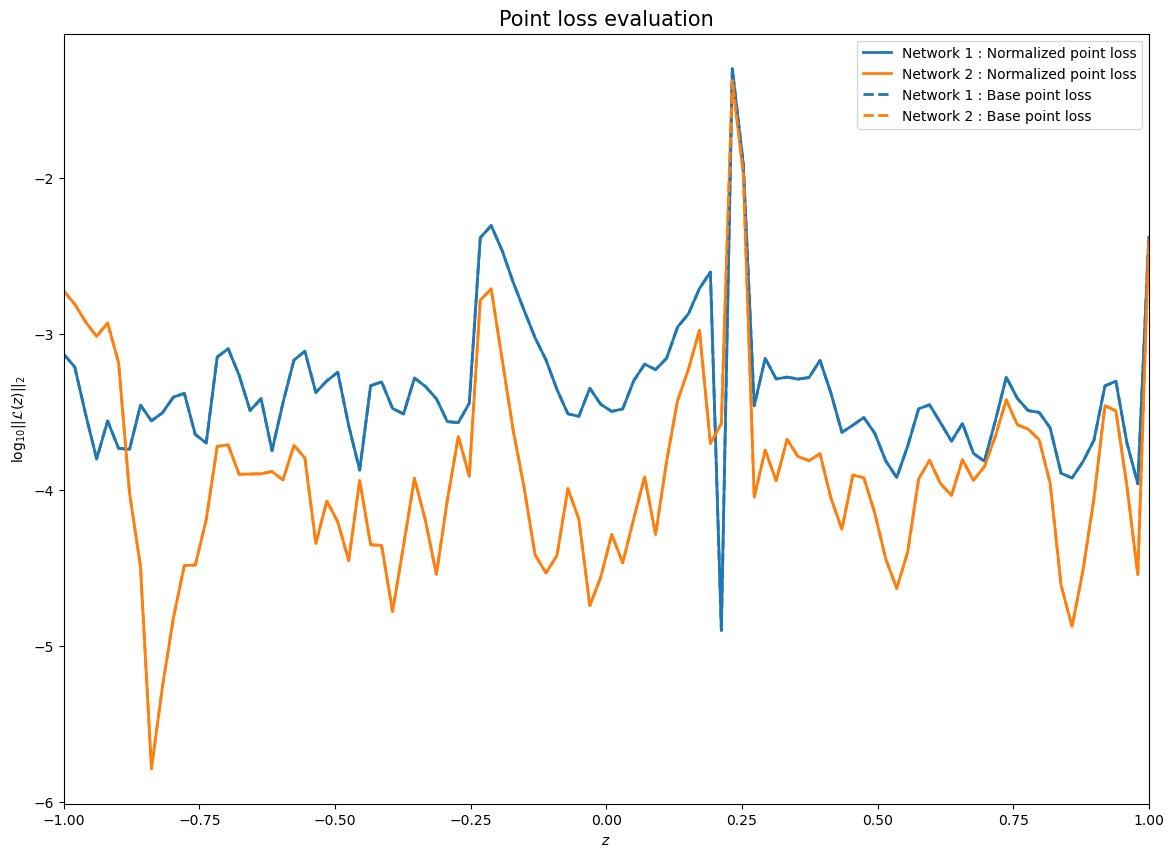

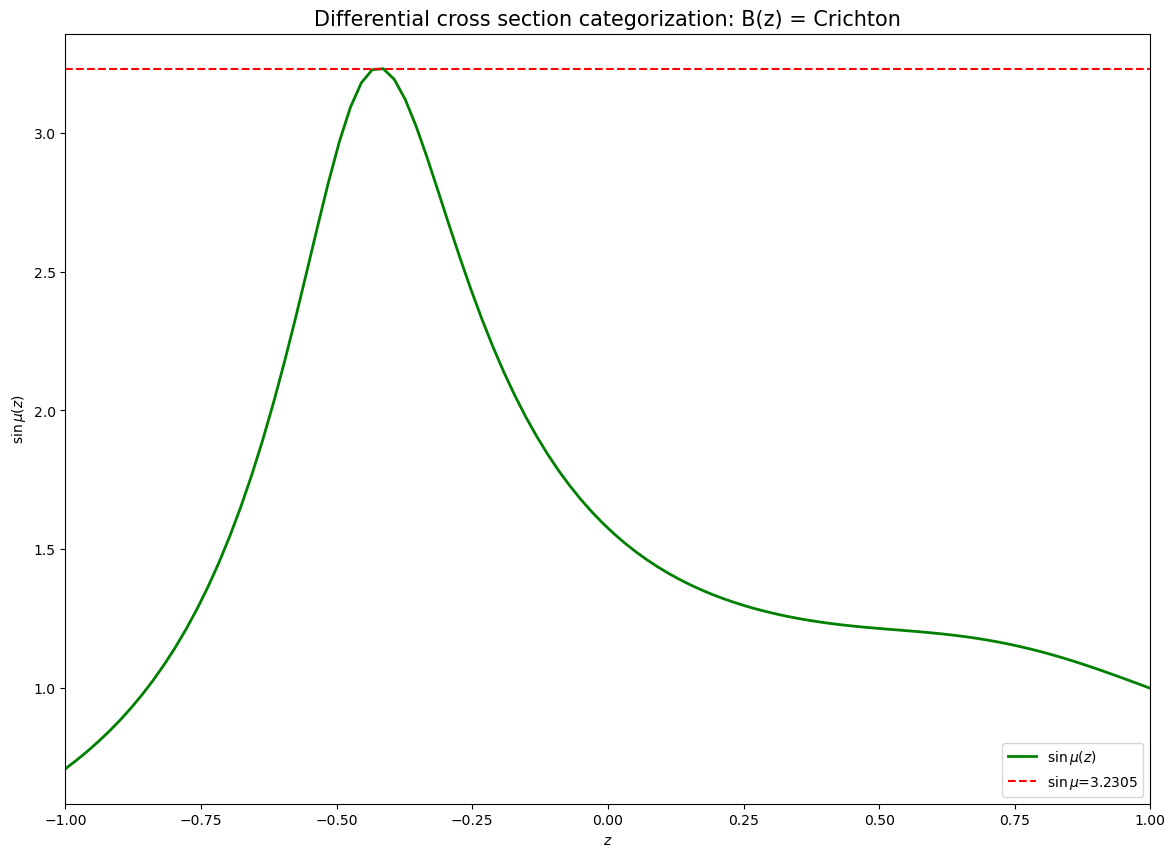

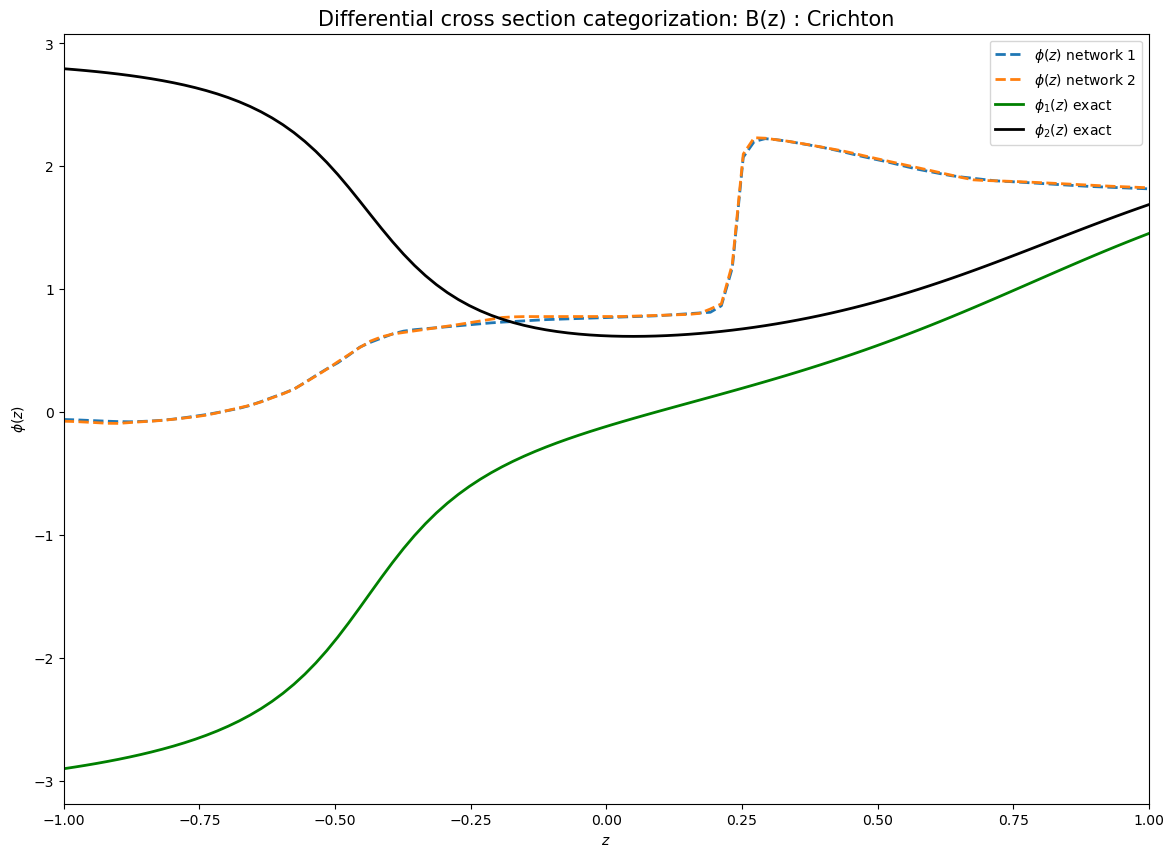

In [251]:
crichtonnet = ModuleNetCrichton()
netsolver = train_run(params, device, run, module_net=crichtonnet, seed_num=42, optim_name='Adam')

phievals = []
eval_pt_loss_ses = []
eval_pt_loss_noses = []
for i in range(params['num_nets']):
    
    if params['num_nets'] > 1: 
        netsolver.phi_net = netsolver.multi_nets[i]
    zpointseval, phieval, _, eval_pt_loss_s, eval_pt_loss_nos = eval_run(netsolver, params, device, run)
    phievals.append(phieval)
    eval_pt_loss_ses.append(eval_pt_loss_s)
    eval_pt_loss_noses.append(eval_pt_loss_nos)

plot_phases(zpointseval, phievals, run)
plot_point_loss_crichton(zpointseval, eval_pt_loss_ses, eval_pt_loss_noses, run)

integralz = sin_mu_integral(params, device, netsolver, zpointseval)
plot_sin_mu(zpointseval, integralz, tags)

plot_summary_crichton(zpointseval, phievals, run)

In [252]:
# Make sure to kill the Neptune logger run
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 71 operations to synchronize with Neptune. Do not kill this process.
All 71 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-795


In [253]:
lambda_list = np.array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05, 0.  ])

In [256]:
non_scaled_losses = [[tensor(7.2174, device='mps:0'), tensor(2.9587, device='mps:0')],
 [tensor(6.7280, device='mps:0'), tensor(2.7196, device='mps:0')],
 [tensor(6.2648, device='mps:0'), tensor(2.4956, device='mps:0')],
 [tensor(5.8269, device='mps:0'), tensor(2.2868, device='mps:0')],
 [tensor(5.4165, device='mps:0'), tensor(2.0942, device='mps:0')],
 [tensor(5.0323, device='mps:0'), tensor(1.9132, device='mps:0')],
 [tensor(4.6736, device='mps:0'), tensor(1.7477, device='mps:0')],
 [tensor(4.3420, device='mps:0'), tensor(1.5961, device='mps:0')],
 [tensor(4.0351, device='mps:0'), tensor(1.4578, device='mps:0')],
 [tensor(3.7531, device='mps:0'), tensor(1.3337, device='mps:0')],
 [tensor(3.4962, device='mps:0'), tensor(1.2215, device='mps:0')],
 [tensor(3.2653, device='mps:0'), tensor(1.1192, device='mps:0')],
 [tensor(3.0591, device='mps:0'), tensor(1.0319, device='mps:0')],
 [tensor(2.8768, device='mps:0'), tensor(0.9539, device='mps:0')],
 [tensor(2.7187, device='mps:0'), tensor(0.8877, device='mps:0')],
 [tensor(2.5849, device='mps:0'), tensor(0.8318, device='mps:0')],
 [tensor(2.4750, device='mps:0'), tensor(0.7872, device='mps:0')],
 [tensor(2.3899, device='mps:0'), tensor(0.7524, device='mps:0')],
 [tensor(2.3296, device='mps:0'), tensor(0.7273, device='mps:0')],
 [tensor(2.2940, device='mps:0'), tensor(0.7130, device='mps:0')],
 [tensor(2.2826, device='mps:0'), tensor(0.7075, device='mps:0')]]

In [257]:
scaled_losses = [[tensor(16.6903, device='mps:0'), tensor(153.3921, device='mps:0')],
 [tensor(15.5568, device='mps:0'), tensor(138.3149, device='mps:0')],
 [tensor(14.5653, device='mps:0'), tensor(125.1602, device='mps:0')],
 [tensor(13.6976, device='mps:0'), tensor(113.8143, device='mps:0')],
 [tensor(12.9217, device='mps:0'), tensor(103.8960, device='mps:0')],
 [tensor(12.2305, device='mps:0'), tensor(94.8370, device='mps:0')],
 [tensor(11.6162, device='mps:0'), tensor(87.0729, device='mps:0')],
 [tensor(11.0603, device='mps:0'), tensor(80.2208, device='mps:0')],
 [tensor(10.5677, device='mps:0'), tensor(74.1467, device='mps:0')],
 [tensor(10.1297, device='mps:0'), tensor(69.0396, device='mps:0')],
 [tensor(9.7404, device='mps:0'), tensor(64.2485, device='mps:0')],
 [tensor(9.3894, device='mps:0'), tensor(59.7170, device='mps:0')],
 [tensor(9.0793, device='mps:0'), tensor(56.5725, device='mps:0')],
 [tensor(8.8137, device='mps:0'), tensor(53.4387, device='mps:0')],
 [tensor(8.5878, device='mps:0'), tensor(50.8409, device='mps:0')],
 [tensor(8.4007, device='mps:0'), tensor(48.5519, device='mps:0')],
 [tensor(8.2529, device='mps:0'), tensor(46.9387, device='mps:0')],
 [tensor(8.1388, device='mps:0'), tensor(45.7105, device='mps:0')],
 [tensor(8.0584, device='mps:0'), tensor(44.8736, device='mps:0')],
 [tensor(8.0107, device='mps:0'), tensor(44.6702, device='mps:0')],
 [tensor(7.9962, device='mps:0'), tensor(44.6695, device='mps:0')]]

In [258]:
sinmuvalues = [tensor(3.2310),
 tensor(2.9320),
 tensor(2.6727),
 tensor(2.4466),
 tensor(2.2472),
 tensor(2.0707),
 tensor(1.9139),
 tensor(1.7742),
 tensor(1.6497),
 tensor(1.5388),
 tensor(1.4408),
 tensor(1.3539),
 tensor(1.2773),
 tensor(1.2109),
 tensor(1.1538),
 tensor(1.1059),
 tensor(1.0670),
 tensor(1.0369),
 tensor(1.0157),
 tensor(1.0033),
 tensor(0.9881)]

In [262]:
from numpy import array, float32

In [263]:
solved_phases = [[array([-0.60560405, -0.60515565, -0.6047072 , -0.6041705 , -0.6036363 ,
         -0.60310227, -0.60256803, -0.6020338 , -0.601556  , -0.60111135,
         -0.6006544 , -0.6001329 , -0.5996114 , -0.5989997 , -0.5983402 ,
         -0.5977658 , -0.59709364, -0.5964125 , -0.59580576, -0.5956999 ,
         -0.5956493 , -0.59561193, -0.5956933 , -0.5957778 , -0.5958625 ,
         -0.59596854, -0.5960747 , -0.596195  , -0.5963282 , -0.5963373 ,
         -0.5962166 , -0.59568137, -0.595119  , -0.5945476 , -0.5939836 ,
         -0.59332174, -0.5926105 , -0.59187555, -0.591098  , -0.59032035,
         -0.5895649 , -0.58880717, -0.58800906, -0.5872138 , -0.5864218 ,
         -0.5856297 , -0.58481425, -0.58392656, -0.5830116 , -0.5821309 ,
         -0.5812793 , -0.58007395, -0.5788344 , -0.5775949 , -0.57636267,
         -0.5748664 , -0.5733455 , -0.5719038 , -0.57054347, -0.5691103 ,
         -0.5677646 , -0.56658006, -0.56508386, -0.56364894, -0.56202096,
         -0.5602322 , -0.5590624 , -0.5578213 , -0.55649287, -0.55531585,
         -0.55415046, -0.5529899 , -0.551817  , -0.55053777, -0.549135  ,
         -0.5477454 , -0.5464147 , -0.5451143 , -0.54385144, -0.54255366,
         -0.54119486, -0.53996557, -0.53889227, -0.5379141 , -0.5369713 ,
         -0.5357655 , -0.5347336 , -0.53406394, -0.53349   , -0.53283435,
         -0.5319685 , -0.53110254, -0.5303164 , -0.5295087 , -0.5287437 ,
         -0.5284089 , -0.5281175 , -0.5278246 , -0.5275317 , -0.52723885],
        dtype=float32),
  array([0.21232527, 0.2105797 , 0.20883428, 0.20716526, 0.20552345,
         0.20352934, 0.2011313 , 0.19873284, 0.19636895, 0.19404627,
         0.19157036, 0.18908694, 0.18637899, 0.18360235, 0.18096581,
         0.17835005, 0.17573033, 0.17295486, 0.17015089, 0.16731107,
         0.16445035, 0.16173004, 0.1588962 , 0.15595718, 0.15295035,
         0.1500677 , 0.14743344, 0.1445434 , 0.14164788, 0.13875622,
         0.13591774, 0.13314293, 0.13036783, 0.12758638, 0.12490408,
         0.122713  , 0.12084996, 0.11933695, 0.11792357, 0.11650713,
         0.11523271, 0.11402193, 0.11291756, 0.11229735, 0.1117361 ,
         0.11117327, 0.1105431 , 0.10995644, 0.10977038, 0.10967531,
         0.10974368, 0.10984711, 0.11000491, 0.1101627 , 0.11027464,
         0.11037627, 0.11047789, 0.11048157, 0.11065029, 0.11050003,
         0.11033478, 0.11008529, 0.10992644, 0.10976739, 0.10966223,
         0.10980716, 0.11010779, 0.11047773, 0.11103351, 0.11166016,
         0.11228272, 0.11289772, 0.11365165, 0.11441126, 0.11517102,
         0.11605251, 0.11711398, 0.11827269, 0.11932481, 0.12061707,
         0.12165026, 0.12293862, 0.12426182, 0.12568016, 0.12709837,
         0.12842982, 0.12971447, 0.13085048, 0.13189748, 0.13293052,
         0.13399564, 0.13514504, 0.1362941 , 0.1374433 , 0.1385923 ,
         0.13974832, 0.14093213, 0.14205731, 0.14349578, 0.14504041],
        dtype=float32)],
 [array([-0.60585904, -0.6054089 , -0.6049588 , -0.60442007, -0.6038841 ,
         -0.60334814, -0.60281193, -0.60227597, -0.6017952 , -0.6013394 ,
         -0.6008816 , -0.6003591 , -0.5998203 , -0.5991937 , -0.5985337 ,
         -0.597932  , -0.5972581 , -0.5965313 , -0.59594476, -0.59583753,
         -0.5957859 , -0.59574765, -0.5958282 , -0.59591174, -0.59599555,
         -0.59607935, -0.59617275, -0.59629256, -0.59642565, -0.5964346 ,
         -0.5962998 , -0.5957429 , -0.5952112 , -0.5946466 , -0.5940821 ,
         -0.59341836, -0.5927051 , -0.59196836, -0.59118885, -0.5904094 ,
         -0.5896612 , -0.5889078 , -0.58810925, -0.58731276, -0.5865188 ,
         -0.5857248 , -0.58490676, -0.5840167 , -0.58309966, -0.5822165 ,
         -0.58136183, -0.58017623, -0.5789346 , -0.5776929 , -0.5764588 ,
         -0.5749578 , -0.5734334 , -0.5719934 , -0.57063824, -0.5692117 ,
         -0.56786245, -0.5666796 , -0.56521064, -0.5637908 , -0.5621558 ,
         -0.5603842 , -0.55921   , -0.557947  , -0.5566139 , -0.5553404 ,
         -0.55415165, -0.5529845 , -0.55180717, -0.5505234 , -0.54911596,
         -0.5477179 , -0.54638416, -0.5450642 , -0.5437982 , -0.54249704,
         -0.54113454, -0.5398889 , -0.53885084, -0.5378564 , -0.5368883 ,
         -0.5356667 , -0.534598  , -0.53391075, -0.53332114, -0.532685  ,
         -0.5318044 , -0.5309613 , -0.5301641 , -0.52934366, -0.5285556 ,
         -0.52819616, -0.52789176, -0.5275874 , -0.52728295, -0.52697843],
        dtype=float32),
  array([0.21224205, 0.21049587, 0.20874979, 0.20709237, 0.20544983,
         0.20345823, 0.2010593 , 0.19866021, 0.19629095, 0.19396764,
         0.19149356, 0.18900919, 0.1863006 , 0.18352315, 0.18088597,
         0.17826909, 0.17564857, 0.17286891, 0.17006412, 0.16722365,
         0.16436224, 0.161651  , 0.15881635, 0.15587685, 0.152869  ,
         0.1499801 , 0.14734499, 0.14445527, 0.14155908, 0.1386729 ,
         0.13583323, 0.1330576 , 0.1302818 , 0.12750125, 0.12481412,
         0.12262655, 0.12076371, 0.11924302, 0.11782765, 0.11641093,
         0.11513539, 0.1139242 , 0.11281957, 0.11219341, 0.11163178,
         0.11106941, 0.11043659, 0.10989923, 0.1097135 , 0.10961881,
         0.10968648, 0.1097899 , 0.10994772, 0.11010569, 0.11021709,
         0.11031891, 0.11042072, 0.11042229, 0.11059172, 0.11044373,
         0.11027846, 0.11002897, 0.10986993, 0.10971089, 0.10961078,
         0.109762  , 0.11006332, 0.11043327, 0.11099587, 0.11162236,
         0.11224216, 0.11285701, 0.1136118 , 0.11437146, 0.11513106,
         0.11601638, 0.1170777 , 0.11823697, 0.11929223, 0.1205861 ,
         0.12161876, 0.12290889, 0.12424299, 0.125661  , 0.12707907,
         0.12841   , 0.12969416, 0.13083793, 0.13188459, 0.13291748,
         0.1339977 , 0.13514659, 0.13629547, 0.13744451, 0.13859335,
         0.139749  , 0.14093399, 0.142059  , 0.14350107, 0.14504518],
        dtype=float32)],
 [array([-0.6058978 , -0.6054473 , -0.6049968 , -0.6044575 , -0.603921  ,
         -0.60338444, -0.602848  , -0.6023114 , -0.6018248 , -0.6013704 ,
         -0.6009128 , -0.6003899 , -0.59985006, -0.5992235 , -0.5985629 ,
         -0.59795415, -0.59728116, -0.5965473 , -0.5959597 , -0.59585285,
         -0.5958011 , -0.5957625 , -0.59584236, -0.5959258 , -0.5960094 ,
         -0.596093  , -0.5961847 , -0.59630436, -0.59643716, -0.59644604,
         -0.5963105 , -0.59575343, -0.5952232 , -0.5946585 , -0.59409374,
         -0.59343016, -0.5927167 , -0.59197974, -0.5912003 , -0.59042054,
         -0.58967286, -0.5889192 , -0.58812255, -0.58732593, -0.5865319 ,
         -0.5857379 , -0.58491874, -0.58402735, -0.58311033, -0.58222735,
         -0.58137417, -0.58019185, -0.5789503 , -0.5777084 , -0.57647413,
         -0.5749724 , -0.5734478 , -0.5720076 , -0.57065254, -0.569229  ,
         -0.56788   , -0.56669825, -0.5652292 , -0.56381184, -0.56218266,
         -0.5603971 , -0.55922294, -0.55796725, -0.5566342 , -0.5553759 ,
         -0.55418754, -0.5530193 , -0.5518447 , -0.5505692 , -0.5491537 ,
         -0.54775804, -0.54642487, -0.5451042 , -0.543839  , -0.5425407 ,
         -0.54117894, -0.5399209 , -0.53891116, -0.53792   , -0.5369425 ,
         -0.5357217 , -0.5346502 , -0.53396434, -0.5333747 , -0.5327072 ,
         -0.5318274 , -0.5309724 , -0.5301761 , -0.52935636, -0.5285706 ,
         -0.52820414, -0.5279003 , -0.5275966 , -0.52729267, -0.5269888 ],
        dtype=float32),
  array([0.212216  , 0.21047014, 0.20872414, 0.20706753, 0.20542514,
         0.20343435, 0.20103568, 0.19863673, 0.19626792, 0.1939449 ,
         0.19147111, 0.18898705, 0.18627824, 0.18350105, 0.18086433,
         0.17824757, 0.17562722, 0.17284767, 0.170043  , 0.16720247,
         0.16434123, 0.16163029, 0.15879576, 0.15585639, 0.15284868,
         0.14996141, 0.14732628, 0.14443669, 0.14154048, 0.13865459,
         0.13581508, 0.13303958, 0.13026392, 0.12748332, 0.12479738,
         0.12260994, 0.12074728, 0.11922656, 0.11781116, 0.11639444,
         0.11511855, 0.1139075 , 0.11280286, 0.11217652, 0.1116147 ,
         0.11104589, 0.11041305, 0.10987604, 0.10969032, 0.1095956 ,
         0.10966258, 0.109766  , 0.109924  , 0.11008181, 0.11019322,
         0.11029503, 0.11039685, 0.11039859, 0.11056802, 0.11041723,
         0.11025197, 0.11000265, 0.10984362, 0.10968457, 0.10958444,
         0.10973565, 0.11003646, 0.11040608, 0.11096974, 0.11159606,
         0.11221517, 0.11283002, 0.11358485, 0.11434433, 0.11510378,
         0.11598913, 0.11705045, 0.1182094 , 0.11926451, 0.12055838,
         0.12159073, 0.12288123, 0.12421501, 0.12563288, 0.12705044,
         0.12838106, 0.1296649 , 0.13080868, 0.13185504, 0.13288741,
         0.1339565 , 0.13510509, 0.13625365, 0.13740203, 0.1385504 ,
         0.1397054 , 0.14089026, 0.14201513, 0.14344838, 0.14499237],
        dtype=float32)],
 [array([-0.60545814, -0.60501224, -0.6045663 , -0.60403204, -0.6035014 ,
         -0.60297096, -0.60244024, -0.6019096 , -0.6014235 , -0.60098547,
         -0.60053325, -0.60001385, -0.59949446, -0.59889346, -0.59823436,
         -0.5976551 , -0.5969824 , -0.5962627 , -0.5956532 , -0.5955475 ,
         -0.5954976 , -0.5954605 , -0.59554213, -0.5956268 , -0.59571147,
         -0.5957961 , -0.5958818 , -0.5960031 , -0.5961372 , -0.5961472 ,
         -0.5960275 , -0.595518  , -0.5949908 , -0.5944273 , -0.5938636 ,
         -0.59320104, -0.5924891 , -0.59175324, -0.5909751 , -0.59019685,
         -0.5894431 , -0.58869207, -0.5878997 , -0.5871017 , -0.5863091 ,
         -0.58551615, -0.58469903, -0.5838129 , -0.58289766, -0.5820162 ,
         -0.5811721 , -0.5800134 , -0.57877344, -0.57753336, -0.576301  ,
         -0.5748001 , -0.57327616, -0.5718322 , -0.57047015, -0.56908363,
         -0.56773627, -0.56655085, -0.5650536 , -0.56362695, -0.5620388 ,
         -0.5602508 , -0.55907875, -0.5578316 , -0.55649936, -0.5552367 ,
         -0.5540562 , -0.5528925 , -0.5517167 , -0.5504647 , -0.5490441 ,
         -0.54766715, -0.54633427, -0.5450101 , -0.5437451 , -0.5424511 ,
         -0.5410895 , -0.53982383, -0.53877276, -0.5377823 , -0.53682554,
         -0.535606  , -0.5345409 , -0.5338605 , -0.5332705 , -0.5326079 ,
         -0.53172886, -0.5309582 , -0.5301621 , -0.5293413 , -0.5285506 ,
         -0.5281832 , -0.5278783 , -0.5275736 , -0.52726877, -0.5269639 ],
        dtype=float32),
  array([0.21214518, 0.21039778, 0.20865037, 0.20699191, 0.2053481 ,
         0.20336504, 0.20096514, 0.19856474, 0.19619861, 0.19387418,
         0.19140224, 0.18891674, 0.18620701, 0.18342902, 0.18079117,
         0.1781736 , 0.17555226, 0.17277043, 0.16996677, 0.1671256 ,
         0.16426335, 0.16155194, 0.15871657, 0.15577622, 0.15276784,
         0.14988653, 0.14725043, 0.14435983, 0.14146297, 0.1385781 ,
         0.13573778, 0.13296126, 0.13018443, 0.12739764, 0.12471035,
         0.12252157, 0.12065828, 0.11913607, 0.11771662, 0.11629564,
         0.11501706, 0.11380419, 0.1126981 , 0.11206978, 0.11150654,
         0.1109335 , 0.11030742, 0.1098239 , 0.10963764, 0.10954224,
         0.10960747, 0.10971037, 0.10986751, 0.11002461, 0.11013516,
         0.1102361 , 0.11033704, 0.11033827, 0.1105063 , 0.1103557 ,
         0.11018956, 0.10993987, 0.10977995, 0.1096202 , 0.10952184,
         0.1096762 , 0.10997666, 0.11034577, 0.11090335, 0.11152883,
         0.11214709, 0.11276093, 0.1135156 , 0.11427408, 0.1150327 ,
         0.11592155, 0.11698189, 0.11814003, 0.11919744, 0.12048668,
         0.12151823, 0.12280808, 0.12415507, 0.12557264, 0.12698992,
         0.12831904, 0.1296026 , 0.1307528 , 0.13179865, 0.1328309 ,
         0.13389574, 0.13504386, 0.13619216, 0.13734022, 0.13848828,
         0.139643  , 0.14082739, 0.14195178, 0.14340165, 0.14494552],
        dtype=float32)],
 [array([-0.6055433 , -0.60509306, -0.6046428 , -0.6041157 , -0.6035795 ,
         -0.6030432 , -0.60250676, -0.6019705 , -0.60147506, -0.6010316 ,
         -0.6005736 , -0.6000505 , -0.59952736, -0.59891665, -0.59825134,
         -0.5976581 , -0.59698653, -0.5962497 , -0.5956347 , -0.5955293 ,
         -0.59547913, -0.59544206, -0.59552103, -0.59560585, -0.5956905 ,
         -0.5957752 , -0.59586   , -0.5959588 , -0.5960927 , -0.59610367,
         -0.59598774, -0.5955016 , -0.5949734 , -0.59441036, -0.59384716,
         -0.59318525, -0.5924737 , -0.5917422 , -0.59096456, -0.59018695,
         -0.58943284, -0.5886819 , -0.5878904 , -0.5870918 , -0.58629894,
         -0.5855063 , -0.584689  , -0.5838069 , -0.58289194, -0.5820112 ,
         -0.5811633 , -0.5799715 , -0.5787317 , -0.5774918 , -0.57626045,
         -0.57475996, -0.5732362 , -0.57180446, -0.57044274, -0.569039  ,
         -0.56769174, -0.56651914, -0.5650193 , -0.56358504, -0.5619987 ,
         -0.5602651 , -0.5590938 , -0.55783653, -0.55648667, -0.55520535,
         -0.55402225, -0.5528546 , -0.5516788 , -0.5504248 , -0.54900473,
         -0.54760265, -0.54627013, -0.5449436 , -0.5436788 , -0.54238266,
         -0.5410212 , -0.5397567 , -0.5387163 , -0.5377253 , -0.5368213 ,
         -0.5356024 , -0.53452605, -0.5338476 , -0.53325933, -0.53262585,
         -0.53175586, -0.53098285, -0.53018785, -0.52937204, -0.5285914 ,
         -0.5282299 , -0.52792716, -0.5276243 , -0.5273215 , -0.5270188 ],
        dtype=float32),
  array([0.20970236, 0.20797944, 0.20630895, 0.20470183, 0.2030838 ,
         0.20129192, 0.19909395, 0.19671799, 0.19439915, 0.19209845,
         0.18965264, 0.18718985, 0.18450345, 0.18174872, 0.17913403,
         0.17654054, 0.17394404, 0.17118011, 0.16840349, 0.16559745,
         0.16275936, 0.16010037, 0.15741432, 0.15459834, 0.15188609,
         0.14936784, 0.14684941, 0.14403254, 0.14120524, 0.13839261,
         0.13561502, 0.13288894, 0.13016257, 0.12743625, 0.1247732 ,
         0.12251534, 0.12066814, 0.11915549, 0.1177423 , 0.11632758,
         0.11505216, 0.11384314, 0.11274091, 0.11212202, 0.1115635 ,
         0.1109863 , 0.11038115, 0.10994197, 0.109762  , 0.10967304,
         0.10972519, 0.10983263, 0.10999566, 0.11015852, 0.11027621,
         0.11038289, 0.11048958, 0.11052793, 0.11070415, 0.11056139,
         0.11040173, 0.11014564, 0.10999166, 0.10983803, 0.10975275,
         0.10990185, 0.11018624, 0.11056123, 0.11110217, 0.11172896,
         0.11234733, 0.1129656 , 0.11372557, 0.11448862, 0.11525166,
         0.11614595, 0.11720996, 0.11837137, 0.11943313, 0.12066989,
         0.12170545, 0.12300917, 0.12436753, 0.12578647, 0.12720525,
         0.12853591, 0.12982221, 0.13103174, 0.13208875, 0.13312493,
         0.13416089, 0.135197  , 0.13623291, 0.13726865, 0.13840152,
         0.13955732, 0.14068969, 0.14181451, 0.14327306, 0.14481977],
        dtype=float32)],
 [array([-0.6054874 , -0.60504097, -0.60459465, -0.6040646 , -0.6035292 ,
         -0.6029938 , -0.60245836, -0.6019226 , -0.60142416, -0.6009889 ,
         -0.60053164, -0.6000087 , -0.59948593, -0.59888816, -0.59822357,
         -0.5976386 , -0.59696746, -0.5962167 , -0.5955976 , -0.5954926 ,
         -0.5954429 , -0.5954062 , -0.5954857 , -0.59557074, -0.59565586,
         -0.5957408 , -0.595826  , -0.59592557, -0.5960557 , -0.59606713,
         -0.5959556 , -0.5954659 , -0.5949386 , -0.594376  , -0.5938134 ,
         -0.59315205, -0.59244114, -0.5917097 , -0.5909326 , -0.5901554 ,
         -0.5894031 , -0.5886527 , -0.58785903, -0.5870612 , -0.5862681 ,
         -0.58547634, -0.5846582 , -0.58377695, -0.5828628 , -0.5819828 ,
         -0.5811396 , -0.57997936, -0.57873994, -0.5775    , -0.5762689 ,
         -0.57476866, -0.57324034, -0.5718002 , -0.5704372 , -0.5690388 ,
         -0.56769216, -0.56652015, -0.5650211 , -0.5635858 , -0.56199306,
         -0.56025827, -0.55908734, -0.55783856, -0.55648726, -0.55520165,
         -0.5540181 , -0.5528523 , -0.5516772 , -0.550431  , -0.5490114 ,
         -0.5476106 , -0.54627854, -0.544951  , -0.54368687, -0.54239404,
         -0.5410333 , -0.53976303, -0.5387571 , -0.5377663 , -0.5368687 ,
         -0.53565013, -0.53458524, -0.53390807, -0.53331906, -0.53267556,
         -0.53179896, -0.5310181 , -0.5302239 , -0.52940935, -0.52862865,
         -0.52826786, -0.5279657 , -0.5276636 , -0.52736163, -0.5270595 ],
        dtype=float32),
  array([0.2107609 , 0.20903745, 0.20736848, 0.2057578 , 0.20413569,
         0.20223214, 0.19985221, 0.1974722 , 0.19512407, 0.19281957,
         0.1903756 , 0.18791021, 0.18522117, 0.18246391, 0.17984718,
         0.17725177, 0.1746485 , 0.17188086, 0.16910201, 0.16629732,
         0.16345584, 0.16077432, 0.15795961, 0.15503924, 0.15224692,
         0.14962703, 0.14700699, 0.14414471, 0.14126639, 0.13841215,
         0.1355857 , 0.13282385, 0.13008359, 0.12736335, 0.1247302 ,
         0.12250878, 0.12065465, 0.11914023, 0.11772824, 0.11631386,
         0.1150447 , 0.11383603, 0.11273395, 0.11212151, 0.11156698,
         0.11099257, 0.11039197, 0.10994807, 0.10977264, 0.10968806,
         0.10974211, 0.10985354, 0.11001102, 0.11017874, 0.11030131,
         0.11041272, 0.11052391, 0.11056209, 0.11074806, 0.1106088 ,
         0.11045385, 0.1102035 , 0.11005443, 0.10990534, 0.10983994,
         0.11001398, 0.11030462, 0.11068375, 0.11121717, 0.11183956,
         0.11246205, 0.11308462, 0.11384732, 0.11461466, 0.1153818 ,
         0.11627237, 0.11733976, 0.1185042 , 0.11955944, 0.12078917,
         0.12182761, 0.1231357 , 0.12445959, 0.12587327, 0.1272925 ,
         0.12861067, 0.12989707, 0.13110688, 0.13219804, 0.13323446,
         0.13427071, 0.13530709, 0.13634329, 0.13749792, 0.13878547,
         0.14009805, 0.14135757, 0.14260958, 0.14414677, 0.14569786],
        dtype=float32)],
 [array([-0.6053883 , -0.6049404 , -0.60449266, -0.60396105, -0.60342425,
         -0.60288763, -0.6023508 , -0.6018139 , -0.60133195, -0.60089123,
         -0.6004327 , -0.5999078 , -0.5993829 , -0.59879065, -0.59811825,
         -0.5975325 , -0.59685856, -0.5960866 , -0.5954608 , -0.5953534 ,
         -0.5953018 , -0.595263  , -0.59534085, -0.5954243 , -0.59550774,
         -0.59559125, -0.59567475, -0.5957724 , -0.59589857, -0.5959083 ,
         -0.59579784, -0.59530747, -0.59477836, -0.5942143 , -0.5936502 ,
         -0.5929871 , -0.5922737 , -0.5915392 , -0.5907599 , -0.5899803 ,
         -0.58922607, -0.5884738 , -0.5876865 , -0.58688647, -0.58608955,
         -0.5852955 , -0.5844792 , -0.58359694, -0.5826798 , -0.58179724,
         -0.58091223, -0.57976586, -0.5785242 , -0.5772821 , -0.57604676,
         -0.57454354, -0.57301205, -0.5715677 , -0.57019883, -0.56883395,
         -0.5674834 , -0.56631064, -0.5648071 , -0.56336886, -0.56179607,
         -0.5601233 , -0.55905277, -0.5577443 , -0.55633926, -0.55498135,
         -0.5537676 , -0.55258834, -0.55140865, -0.5502202 , -0.5488451 ,
         -0.54743373, -0.54607904, -0.5447426 , -0.5434381 , -0.5421693 ,
         -0.5408219 , -0.5395144 , -0.53849506, -0.5375416 , -0.53666216,
         -0.53561074, -0.53452927, -0.533845  , -0.5332421 , -0.5326151 ,
         -0.531848  , -0.53108096, -0.5303209 , -0.5295033 , -0.52871895,
         -0.5283602 , -0.5280525 , -0.52774465, -0.52743673, -0.5271288 ],
        dtype=float32),
  array([0.21072684, 0.20900384, 0.20733564, 0.20572524, 0.20410341,
         0.20220098, 0.19982134, 0.19744144, 0.19509391, 0.19278952,
         0.19034602, 0.18788092, 0.18519214, 0.18243502, 0.17981854,
         0.17722343, 0.17462027, 0.17185292, 0.1690742 , 0.16626978,
         0.16342841, 0.16074717, 0.15793277, 0.15501232, 0.15222201,
         0.14960223, 0.14698212, 0.14411983, 0.14124213, 0.13838802,
         0.13556169, 0.1327998 , 0.13006037, 0.12734023, 0.12470758,
         0.12248646, 0.12063231, 0.11911787, 0.11770584, 0.11629182,
         0.11502245, 0.11381375, 0.1127115 , 0.11209885, 0.11154451,
         0.11096503, 0.11036459, 0.10992086, 0.10974543, 0.10966066,
         0.10971439, 0.10982564, 0.10998293, 0.11015084, 0.11027325,
         0.11038464, 0.11049602, 0.11053386, 0.11072   , 0.11057848,
         0.11042351, 0.11017316, 0.11002427, 0.10987517, 0.10981014,
         0.10998434, 0.11027464, 0.11065359, 0.11118808, 0.11181065,
         0.11243314, 0.11305556, 0.11381844, 0.11458564, 0.11535262,
         0.11624353, 0.11731078, 0.11847541, 0.1195305 , 0.12076044,
         0.1217987 , 0.12310667, 0.12443076, 0.12584375, 0.12726268,
         0.12858036, 0.12986644, 0.13107611, 0.1321678 , 0.13320391,
         0.13423982, 0.13527606, 0.13631192, 0.13746007, 0.13873929,
         0.1400514 , 0.14131029, 0.14256163, 0.14409767, 0.14564814],
        dtype=float32)],
 [array([-0.6055277 , -0.6050797 , -0.60463166, -0.6040995 , -0.60356224,
         -0.60302514, -0.6024878 , -0.6019505 , -0.60146785, -0.6010252 ,
         -0.60056674, -0.6000422 , -0.5995175 , -0.59891856, -0.59824646,
         -0.5976489 , -0.5969763 , -0.5961855 , -0.59555864, -0.5954519 ,
         -0.59540063, -0.59536225, -0.5954401 , -0.59552383, -0.5956077 ,
         -0.59569156, -0.5957752 , -0.59587324, -0.5959961 , -0.5960062 ,
         -0.59589946, -0.59541786, -0.5948889 , -0.59432465, -0.5937605 ,
         -0.59309655, -0.59238267, -0.5916477 , -0.5908677 , -0.5900874 ,
         -0.5893346 , -0.5885834 , -0.5877991 , -0.5869985 , -0.58620065,
         -0.5854062 , -0.5845864 , -0.5837003 , -0.5827829 , -0.58189994,
         -0.5810538 , -0.5799081 , -0.57866627, -0.5774241 , -0.5761901 ,
         -0.5746867 , -0.5731548 , -0.571709  , -0.5703384 , -0.56898266,
         -0.5676321 , -0.56646436, -0.56496155, -0.5635227 , -0.5619534 ,
         -0.56027734, -0.5592078 , -0.557887  , -0.55649316, -0.55513006,
         -0.5538881 , -0.5527098 , -0.5515317 , -0.550343  , -0.54896647,
         -0.5475464 , -0.54619133, -0.5448572 , -0.5435326 , -0.5422658 ,
         -0.5409333 , -0.5396282 , -0.53853285, -0.53761214, -0.5367335 ,
         -0.5357106 , -0.5346172 , -0.5339336 , -0.53333074, -0.53270656,
         -0.53194064, -0.5311744 , -0.53041524, -0.52960813, -0.52880675,
         -0.5284433 , -0.5281365 , -0.5278298 , -0.5275229 , -0.5272162 ],
        dtype=float32),
  array([0.2106861 , 0.20896418, 0.20730102, 0.20569173, 0.20407085,
         0.2021728 , 0.19979405, 0.19741514, 0.19506939, 0.1927656 ,
         0.19032289, 0.18785857, 0.18517041, 0.18241423, 0.1797984 ,
         0.17720425, 0.17460172, 0.17183518, 0.16905744, 0.16625348,
         0.16341291, 0.16073252, 0.1579189 , 0.15499897, 0.15221046,
         0.14959069, 0.14697073, 0.14410841, 0.14123088, 0.13837671,
         0.1355504 , 0.13278864, 0.13004987, 0.12732989, 0.12469722,
         0.12247608, 0.12062209, 0.11910765, 0.11769562, 0.11628139,
         0.11501203, 0.11380314, 0.11270106, 0.11208823, 0.11153387,
         0.11095423, 0.11035361, 0.10990988, 0.10973426, 0.10964968,
         0.10970252, 0.10981379, 0.10997108, 0.11013865, 0.1102612 ,
         0.11037243, 0.11048383, 0.11052149, 0.11070764, 0.11056611,
         0.11041132, 0.11016098, 0.11001173, 0.10986279, 0.10979757,
         0.10997159, 0.11026155, 0.11064053, 0.11117518, 0.11179741,
         0.11241991, 0.11304234, 0.11380523, 0.11457225, 0.11533924,
         0.11623018, 0.11729742, 0.11846173, 0.11951682, 0.12074677,
         0.12178487, 0.12309267, 0.1244171 , 0.12582995, 0.12724853,
         0.1285659 , 0.12985197, 0.1310615 , 0.13215351, 0.1331893 ,
         0.13422507, 0.13526097, 0.13629684, 0.13733251, 0.13845286,
         0.13960844, 0.14073753, 0.14186183, 0.14335509, 0.14490122],
        dtype=float32)],
 [array([-0.60545844, -0.6050091 , -0.6045596 , -0.6040216 , -0.6034832 ,
         -0.6029448 , -0.60240644, -0.60186785, -0.60138094, -0.60094124,
         -0.6004821 , -0.5999563 , -0.5994303 , -0.5988359 , -0.5981629 ,
         -0.59756905, -0.59689534, -0.5961066 , -0.5954726 , -0.5953639 ,
         -0.595311  , -0.59527093, -0.5953476 , -0.5954298 , -0.59551185,
         -0.595594  , -0.5956762 , -0.595773  , -0.59589535, -0.59590364,
         -0.5957944 , -0.59530324, -0.5947726 , -0.5942071 , -0.59364134,
         -0.59297657, -0.5922614 , -0.5915247 , -0.5907437 , -0.5899625 ,
         -0.58920646, -0.58845353, -0.5876731 , -0.5868717 , -0.5860732 ,
         -0.5852776 , -0.58446044, -0.58357483, -0.5826561 , -0.58177215,
         -0.5808893 , -0.5797634 , -0.57852066, -0.5772775 , -0.5760431 ,
         -0.57453895, -0.5730062 , -0.5715583 , -0.57018584, -0.5688442 ,
         -0.56749326, -0.5663223 , -0.56481904, -0.56337845, -0.56181717,
         -0.56014526, -0.55907536, -0.5577519 , -0.55637366, -0.5550118 ,
         -0.55376506, -0.5525863 , -0.5514075 , -0.55021703, -0.54888123,
         -0.5474603 , -0.54610205, -0.5447672 , -0.5434321 , -0.54216075,
         -0.5408382 , -0.5395324 , -0.53839374, -0.5375029 , -0.53662336,
         -0.5356198 , -0.5345353 , -0.53385115, -0.5332564 , -0.532675  ,
         -0.53190875, -0.53114223, -0.5303826 , -0.5296065 , -0.52881235,
         -0.5284485 , -0.52814186, -0.5278354 , -0.52752876, -0.5272222 ],
        dtype=float32),
  array([0.21071903, 0.20899698, 0.207334  , 0.20572428, 0.20410328,
         0.20219214, 0.19981329, 0.19743422, 0.19508834, 0.19278456,
         0.19034187, 0.18787742, 0.18518934, 0.18243268, 0.17981686,
         0.17722243, 0.1746196 , 0.17185292, 0.16907503, 0.16627076,
         0.1634301 , 0.16074717, 0.15793344, 0.15501335, 0.1522269 ,
         0.14960699, 0.14698674, 0.14412409, 0.14124708, 0.13839261,
         0.13556617, 0.13280427, 0.13004212, 0.12731403, 0.12468237,
         0.12246086, 0.12060669, 0.1190924 , 0.11768016, 0.11626612,
         0.11499637, 0.11378766, 0.1126852 , 0.11207169, 0.11151733,
         0.11093732, 0.11033686, 0.1098947 , 0.10971874, 0.10963397,
         0.1096863 , 0.10979739, 0.10995469, 0.11012208, 0.11024465,
         0.1103557 , 0.11046693, 0.11050597, 0.1106923 , 0.11055008,
         0.11039492, 0.11014439, 0.10999514, 0.10984588, 0.10978117,
         0.10995522, 0.11024482, 0.11062361, 0.11115985, 0.11178209,
         0.11240426, 0.11302651, 0.11378941, 0.11455625, 0.11532307,
         0.11621401, 0.11728093, 0.11844525, 0.11950036, 0.1207303 ,
         0.12176826, 0.12307571, 0.12440087, 0.12581304, 0.12723166,
         0.12854831, 0.12983407, 0.13104343, 0.13213617, 0.13317162,
         0.13420722, 0.13524297, 0.13627851, 0.13731386, 0.13843182,
         0.13958655, 0.14071515, 0.14183912, 0.14332983, 0.14487584],
        dtype=float32)],
 [array([-0.6051026 , -0.6046554 , -0.6042081 , -0.60367537, -0.6031385 ,
         -0.60260165, -0.6020648 , -0.6015278 , -0.60104144, -0.60060984,
         -0.6001518 , -0.5996299 , -0.599105  , -0.59851205, -0.59784293,
         -0.5973015 , -0.59663385, -0.59587634, -0.59523153, -0.595124  ,
         -0.5950721 , -0.59503317, -0.595109  , -0.5951924 , -0.59527594,
         -0.5953594 , -0.5954429 , -0.59554654, -0.59568006, -0.5956894 ,
         -0.5955684 , -0.59511113, -0.59457934, -0.5940149 , -0.59345037,
         -0.5927871 , -0.59207374, -0.59133995, -0.59056073, -0.58978134,
         -0.58902025, -0.58827007, -0.58747554, -0.58667564, -0.5858791 ,
         -0.5850852 , -0.58427477, -0.58339554, -0.5824784 , -0.58159643,
         -0.58063394, -0.5795397 , -0.57829887, -0.5770581 , -0.57582617,
         -0.5743244 , -0.57279426, -0.5713501 , -0.56997985, -0.56863123,
         -0.56729436, -0.5661216 , -0.5646204 , -0.5631751 , -0.5616185 ,
         -0.5599525 , -0.55888414, -0.55754495, -0.5561909 , -0.5548381 ,
         -0.553585  , -0.55240643, -0.55122757, -0.5500387 , -0.54872835,
         -0.5473075 , -0.5459451 , -0.54460996, -0.54327446, -0.5419995 ,
         -0.54067695, -0.5393535 , -0.5382434 , -0.5373152 , -0.53643715,
         -0.53548396, -0.5343971 , -0.5337151 , -0.53317344, -0.5325899 ,
         -0.53182316, -0.5310565 , -0.53029674, -0.52952814, -0.52874064,
         -0.52837366, -0.52806515, -0.52775663, -0.52744806, -0.5271396 ],
        dtype=float32),
  array([0.20922832, 0.20751238, 0.20588075, 0.20427954, 0.20266762,
         0.20088194, 0.19875453, 0.19638409, 0.19405271, 0.19175754,
         0.1893216 , 0.18686472, 0.18418406, 0.18143485, 0.17882611,
         0.17623845, 0.17364442, 0.17088512, 0.16811414, 0.16531731,
         0.16248459, 0.15983099, 0.15712401, 0.15431358, 0.15163049,
         0.14911743, 0.14660403, 0.14380254, 0.14098711, 0.13819206,
         0.13541923, 0.13269795, 0.12997657, 0.12725492, 0.12461728,
         0.12237457, 0.12051976, 0.11900365, 0.11759204, 0.11617755,
         0.11490668, 0.11369757, 0.11259854, 0.11198096, 0.11142535,
         0.1108183 , 0.11021607, 0.10979443, 0.10961759, 0.10953195,
         0.10958253, 0.10969257, 0.1098492 , 0.11001571, 0.11013602,
         0.11024621, 0.11035656, 0.11039371, 0.11057761, 0.11042543,
         0.11026923, 0.11001955, 0.10986925, 0.10971874, 0.10964932,
         0.10982199, 0.11010517, 0.11048261, 0.11102723, 0.11164851,
         0.11226985, 0.11289111, 0.11365373, 0.11441979, 0.11518562,
         0.11607683, 0.1171428 , 0.11830617, 0.11936104, 0.12053569,
         0.1215729 , 0.12287949, 0.12420483, 0.12561579, 0.12703337,
         0.12834989, 0.12963478, 0.13084309, 0.13193166, 0.13296641,
         0.13400094, 0.1350358 , 0.13607046, 0.13710508, 0.13820301,
         0.1393576 , 0.14048807, 0.14161117, 0.14303185, 0.14457679],
        dtype=float32)],
 [array([-0.6048746 , -0.6044287 , -0.60398275, -0.6034466 , -0.60291106,
         -0.60237503, -0.6018393 , -0.6013034 , -0.60080284, -0.60038793,
         -0.5999302 , -0.59940934, -0.5988846 , -0.59832746, -0.5976619 ,
         -0.59712136, -0.596454  , -0.5956877 , -0.59504485, -0.59493804,
         -0.59488696, -0.59484905, -0.5949304 , -0.5950149 , -0.5950998 ,
         -0.59518427, -0.59526896, -0.59538203, -0.59551656, -0.5955272 ,
         -0.59540683, -0.59495795, -0.5944314 , -0.59386754, -0.59330374,
         -0.5926421 , -0.59193003, -0.5911945 , -0.59041685, -0.58965915,
         -0.5889179 , -0.5881647 , -0.58738065, -0.58658034, -0.5857802 ,
         -0.5849859 , -0.58417434, -0.58330816, -0.58239037, -0.5814501 ,
         -0.5804495 , -0.5793251 , -0.578085  , -0.57684475, -0.57561404,
         -0.57411325, -0.5725842 , -0.57113576, -0.56976646, -0.5684039 ,
         -0.56706697, -0.56589615, -0.5643932 , -0.5628836 , -0.5613152 ,
         -0.55962175, -0.558448  , -0.5572233 , -0.55584145, -0.5545416 ,
         -0.55337507, -0.5522085 , -0.55103123, -0.54984343, -0.5485498 ,
         -0.54712963, -0.5457624 , -0.544426  , -0.5431292 , -0.5418517 ,
         -0.5404861 , -0.5392327 , -0.5381125 , -0.53711206, -0.5362239 ,
         -0.5350775 , -0.5339986 , -0.5333135 , -0.53273994, -0.5321506 ,
         -0.53138125, -0.5306042 , -0.52979374, -0.5289653 , -0.52817774,
         -0.52780235, -0.5274893 , -0.52717626, -0.52686316, -0.52655023],
        dtype=float32),
  array([0.20795283, 0.2062509 , 0.20468678, 0.20309706, 0.20149627,
         0.19972152, 0.19765143, 0.19529156, 0.19299771, 0.19071282,
         0.1883036 , 0.18585646, 0.1831861 , 0.18044752, 0.17785034,
         0.17527467, 0.1726982 , 0.16994567, 0.16718268, 0.1644036 ,
         0.16161226, 0.15921721, 0.15683046, 0.15433373, 0.15181978,
         0.14930566, 0.14679123, 0.14399335, 0.14117023, 0.13837382,
         0.13559926, 0.13287675, 0.13015415, 0.12743142, 0.12477803,
         0.12249166, 0.12063248, 0.11912066, 0.11770829, 0.11629494,
         0.11502209, 0.11381446, 0.11271342, 0.11209311, 0.11153006,
         0.11091398, 0.11031421, 0.10998485, 0.10980681, 0.10971962,
         0.1097735 , 0.10988145, 0.1100356 , 0.11020002, 0.11031891,
         0.11042699, 0.1105349 , 0.11057185, 0.11075312, 0.11060687,
         0.11044861, 0.11019618, 0.11004362, 0.10989138, 0.10981674,
         0.10995922, 0.11023872, 0.1106034 , 0.11106036, 0.11167898,
         0.11229771, 0.11291618, 0.11367651, 0.1144396 , 0.11520282,
         0.11610461, 0.11716865, 0.11832923, 0.11939362, 0.12055354,
         0.12158969, 0.12289472, 0.12431139, 0.125734  , 0.12715234,
         0.12846944, 0.12975492, 0.1309547 , 0.13200384, 0.13303922,
         0.1340744 , 0.13510938, 0.13614449, 0.13717942, 0.13821432,
         0.13925977, 0.14038213, 0.14150923, 0.14296617, 0.14452839],
        dtype=float32)],
 [array([-0.60481834, -0.6043738 , -0.60392934, -0.6033955 , -0.60286146,
         -0.6023272 , -0.601793  , -0.60125875, -0.60076994, -0.60035497,
         -0.5999002 , -0.5993796 , -0.598859  , -0.5982967 , -0.5976279 ,
         -0.59709054, -0.5964272 , -0.59568393, -0.5950449 , -0.5949421 ,
         -0.594895  , -0.5948607 , -0.5949447 , -0.59503245, -0.59512013,
         -0.595208  , -0.59529567, -0.595417  , -0.59555477, -0.5955684 ,
         -0.5954514 , -0.59500045, -0.59448844, -0.5939273 , -0.59336644,
         -0.5927075 , -0.59199876, -0.5912658 , -0.5904912 , -0.5897291 ,
         -0.58899117, -0.58824235, -0.5874576 , -0.5866603 , -0.58586377,
         -0.58507246, -0.5842608 , -0.5833858 , -0.58247143, -0.5815833 ,
         -0.5805869 , -0.57941675, -0.5781797 , -0.57694745, -0.5757217 ,
         -0.57422477, -0.57269996, -0.57125866, -0.5698965 , -0.56853855,
         -0.56722665, -0.5660533 , -0.5645564 , -0.56305766, -0.56150174,
         -0.5597536 , -0.5585865 , -0.5573977 , -0.55603516, -0.55482996,
         -0.5536706 , -0.5525113 , -0.5513469 , -0.55016553, -0.54879105,
         -0.54739237, -0.5460626 , -0.54473263, -0.543405  , -0.5421417 ,
         -0.5407843 , -0.5396042 , -0.5384694 , -0.5374525 , -0.5364841 ,
         -0.53523004, -0.53417766, -0.53350395, -0.53288454, -0.53222746,
         -0.5314602 , -0.5306929 , -0.5298927 , -0.52907276, -0.5282871 ,
         -0.5279208 , -0.5276167 , -0.52731234, -0.52700824, -0.52670383],
        dtype=float32),
  array([0.21072471, 0.20900042, 0.20738532, 0.20577478, 0.20415318,
         0.20227757, 0.19989833, 0.19751874, 0.19515225, 0.19284809,
         0.19040649, 0.18794116, 0.18525265, 0.18249567, 0.17987944,
         0.17728479, 0.17468224, 0.171917  , 0.1691379 , 0.16633996,
         0.16350868, 0.16082743, 0.15801485, 0.15509558, 0.1523244 ,
         0.14970568, 0.14708677, 0.14422807, 0.1413622 , 0.13850848,
         0.13570125, 0.13297981, 0.13025823, 0.1275364 , 0.12489941,
         0.12263051, 0.12075213, 0.11923678, 0.1178219 , 0.11640625,
         0.11513401, 0.11392385, 0.11281854, 0.11218332, 0.11161802,
         0.1110018 , 0.11045297, 0.11012836, 0.10995156, 0.10986576,
         0.10991947, 0.11002968, 0.11018589, 0.11035237, 0.11047389,
         0.11058458, 0.11069491, 0.11072733, 0.11091641, 0.11077856,
         0.11062292, 0.1103672 , 0.11021746, 0.1100757 , 0.11002269,
         0.11018589, 0.11046238, 0.11082911, 0.11129469, 0.11191671,
         0.11253848, 0.11316033, 0.11392611, 0.11469253, 0.11545895,
         0.11634548, 0.11741177, 0.11857511, 0.11962859, 0.12082171,
         0.12185927, 0.12316596, 0.12452403, 0.12596178, 0.12738006,
         0.12869368, 0.12997897, 0.13118786, 0.13229562, 0.13333097,
         0.13436629, 0.13540158, 0.13643685, 0.13760495, 0.13879846,
         0.14008848, 0.14135468, 0.14260566, 0.14414215, 0.14569293],
        dtype=float32)],
 [array([-0.60284054, -0.602536  , -0.6022247 , -0.60183984, -0.6015088 ,
         -0.60117805, -0.6008472 , -0.6005164 , -0.6002129 , -0.59992135,
         -0.5995987 , -0.59919345, -0.59878635, -0.59833306, -0.59780055,
         -0.5972624 , -0.59659886, -0.5958295 , -0.5951902 , -0.59508723,
         -0.5950397 , -0.59500533, -0.59508866, -0.5951762 , -0.5952638 ,
         -0.59535134, -0.5954389 , -0.5955571 , -0.5956946 , -0.59570783,
         -0.5955903 , -0.5951473 , -0.5946386 , -0.59407777, -0.593517  ,
         -0.5928577 , -0.5921485 , -0.59141344, -0.5906384 , -0.58987373,
         -0.5891351 , -0.5883872 , -0.58759415, -0.5867965 , -0.5860001 ,
         -0.5852083 , -0.5843965 , -0.5835198 , -0.5826054 , -0.58170795,
         -0.5807114 , -0.5795262 , -0.578289  , -0.5770627 , -0.5758369 ,
         -0.5743402 , -0.57281554, -0.5713721 , -0.57000947, -0.56865144,
         -0.56734735, -0.56617635, -0.5646806 , -0.5631657 , -0.56159014,
         -0.5598998 , -0.558823  , -0.5575744 , -0.5562285 , -0.5548846 ,
         -0.5537072 , -0.5525347 , -0.55136216, -0.55018055, -0.548851  ,
         -0.5474347 , -0.5460674 , -0.54473704, -0.54340667, -0.54210913,
         -0.5408024 , -0.53945106, -0.538455  , -0.5375301 , -0.53664064,
         -0.53580093, -0.53509825, -0.5347013 , -0.53410417, -0.53353834,
         -0.5328632 , -0.53211737, -0.5313451 , -0.53055227, -0.5298055 ,
         -0.5294815 , -0.52920353, -0.52892137, -0.5286389 , -0.5283566 ],
        dtype=float32),
  array([0.20921625, 0.20749721, 0.20587668, 0.20427272, 0.20265809,
         0.20086983, 0.19874613, 0.19637291, 0.19404264, 0.19174501,
         0.1892993 , 0.1868399 , 0.18415552, 0.18140228, 0.1787898 ,
         0.17619857, 0.17360298, 0.1708384 , 0.1680613 , 0.16526724,
         0.1624317 , 0.15977584, 0.1570931 , 0.15427989, 0.15160166,
         0.1490865 , 0.14657137, 0.14377594, 0.14096442, 0.13816777,
         0.135393  , 0.1326703 , 0.1299475 , 0.12722424, 0.12460397,
         0.12234344, 0.12046451, 0.11895356, 0.11754346, 0.11613136,
         0.1148601 , 0.11365356, 0.11255345, 0.11191444, 0.11129941,
         0.11068427, 0.11012069, 0.10980106, 0.10962439, 0.10953892,
         0.10958689, 0.10969713, 0.1098539 , 0.11002061, 0.11014074,
         0.11025127, 0.11036163, 0.11042178, 0.11056104, 0.11040435,
         0.11024778, 0.10997788, 0.10982634, 0.1096748 , 0.10958235,
         0.10973583, 0.11000282, 0.11036755, 0.11092687, 0.11154798,
         0.11216903, 0.11280409, 0.11357006, 0.11433581, 0.1151017 ,
         0.11599954, 0.11706626, 0.11823143, 0.11928895, 0.12047075,
         0.12150923, 0.12281536, 0.12417424, 0.1256215 , 0.12704027,
         0.1283585 , 0.12964442, 0.13085409, 0.13199183, 0.1330284 ,
         0.13406512, 0.13510184, 0.1361385 , 0.13717513, 0.13821174,
         0.1393005 , 0.14044705, 0.14157292, 0.14292523, 0.14442168],
        dtype=float32)],
 [array([-0.60282326, -0.60252166, -0.6022186 , -0.60183686, -0.60150933,
         -0.6011818 , -0.6008542 , -0.60052675, -0.60021454, -0.59992427,
         -0.5996033 , -0.59920037, -0.59879506, -0.59833586, -0.5978049 ,
         -0.59726816, -0.596607  , -0.5958459 , -0.5952075 , -0.59510595,
         -0.59506017, -0.59502745, -0.59511113, -0.5952002 , -0.5952891 ,
         -0.5953781 , -0.595467  , -0.5955885 , -0.59572744, -0.5957423 ,
         -0.5956264 , -0.5951774 , -0.5946511 , -0.5940918 , -0.5935325 ,
         -0.59287477, -0.59216696, -0.59143376, -0.59066   , -0.58989537,
         -0.58915806, -0.58841074, -0.5876322 , -0.58683544, -0.5860407 ,
         -0.58524984, -0.58443964, -0.5835595 , -0.5826453 , -0.5817633 ,
         -0.5807668 , -0.5795669 , -0.5783302 , -0.5770984 , -0.5758731 ,
         -0.57437646, -0.572852  , -0.57141364, -0.57005256, -0.56869495,
         -0.56736887, -0.56619793, -0.5647025 , -0.563191  , -0.5616327 ,
         -0.559972  , -0.55890846, -0.5576539 , -0.55629534, -0.5549819 ,
         -0.5538217 , -0.5526509 , -0.55147785, -0.5502954 , -0.54896456,
         -0.5475471 , -0.5461819 , -0.5448506 , -0.54351914, -0.5422293 ,
         -0.5409191 , -0.5395632 , -0.5385882 , -0.53760076, -0.5367106 ,
         -0.53586507, -0.53515756, -0.53470784, -0.53411895, -0.5335289 ,
         -0.53284615, -0.5320997 , -0.53132683, -0.5305333 , -0.5297826 ,
         -0.5294578 , -0.5291751 , -0.5288921 , -0.5286092 , -0.5283263 ],
        dtype=float32),
  array([0.21088819, 0.20915867, 0.20748723, 0.20587094, 0.20424305,
         0.20240851, 0.20002297, 0.19763713, 0.19526704, 0.1929568 ,
         0.19050598, 0.18803518, 0.18533906, 0.18257439, 0.17995036,
         0.17734797, 0.17474219, 0.17196652, 0.16917577, 0.16636969,
         0.16353543, 0.16082995, 0.15801027, 0.1550834 , 0.15209144,
         0.1493996 , 0.1467759 , 0.14390911, 0.14103717, 0.13817973,
         0.13534996, 0.13258493, 0.12983099, 0.12710837, 0.12448307,
         0.12223293, 0.12037395, 0.11885632, 0.11744335, 0.11602766,
         0.11475442, 0.11354431, 0.11243889, 0.11179899, 0.11117884,
         0.11056086, 0.10999061, 0.10967863, 0.10950264, 0.10941752,
         0.10947281, 0.10958357, 0.1097409 , 0.10990796, 0.11002845,
         0.11013935, 0.11025023, 0.11033741, 0.11048365, 0.11032467,
         0.11016567, 0.10989105, 0.10973706, 0.10958811, 0.10953299,
         0.10968509, 0.10995592, 0.11031979, 0.11083591, 0.11145689,
         0.11207779, 0.11270715, 0.11347298, 0.1142388 , 0.11500455,
         0.11589375, 0.11696038, 0.11812408, 0.11918321, 0.12037238,
         0.12141059, 0.12271628, 0.12407388, 0.12552914, 0.12694682,
         0.1282641 , 0.1295489 , 0.13075745, 0.1319205 , 0.13295627,
         0.13399184, 0.1350274 , 0.13606292, 0.13716829, 0.13831837,
         0.13947526, 0.14061774, 0.14174385, 0.14309669, 0.14458786],
        dtype=float32)],
 [array([-0.6028606 , -0.60255885, -0.6022557 , -0.6018737 , -0.6015459 ,
         -0.60121816, -0.6008906 , -0.6005629 , -0.6002528 , -0.5999643 ,
         -0.5996431 , -0.5992408 , -0.5988351 , -0.5983815 , -0.59785026,
         -0.5973135 , -0.5966527 , -0.5958836 , -0.59524494, -0.59514344,
         -0.59509736, -0.59506446, -0.59514713, -0.5952362 , -0.59532475,
         -0.5954137 , -0.5955025 , -0.5956257 , -0.59576446, -0.5957791 ,
         -0.59566265, -0.59521216, -0.5946884 , -0.59412885, -0.5935695 ,
         -0.5929114 , -0.5922036 , -0.5914702 , -0.59069616, -0.5899313 ,
         -0.58919376, -0.5884468 , -0.58766973, -0.58687276, -0.5860775 ,
         -0.58528644, -0.5844763 , -0.583595  , -0.5826804 , -0.5818013 ,
         -0.58080703, -0.57960224, -0.57836556, -0.577134  , -0.5759087 ,
         -0.57441247, -0.57288814, -0.57145005, -0.57008964, -0.5687322 ,
         -0.5674065 , -0.5662369 , -0.5647427 , -0.56323147, -0.561675  ,
         -0.5600132 , -0.55894953, -0.55769646, -0.5563497 , -0.5550124 ,
         -0.5538516 , -0.5526789 , -0.55150616, -0.55032384, -0.5489902 ,
         -0.547573  , -0.54620355, -0.5448725 , -0.54354125, -0.54224455,
         -0.54094046, -0.5395967 , -0.53854233, -0.53759056, -0.5367003 ,
         -0.5358582 , -0.5351485 , -0.53472996, -0.5341417 , -0.5335639 ,
         -0.53289527, -0.53214926, -0.53137684, -0.530584  , -0.52983385,
         -0.5295097 , -0.5292332 , -0.52895087, -0.5286684 , -0.5283862 ],
        dtype=float32),
  array([0.21080035, 0.20907092, 0.20739771, 0.20578167, 0.20415382,
         0.2023513 , 0.19998093, 0.19759521, 0.19522454, 0.19291456,
         0.19046399, 0.18799312, 0.18529728, 0.18253252, 0.17990857,
         0.17730628, 0.17470145, 0.1719262 , 0.16913572, 0.16632973,
         0.16349523, 0.16079658, 0.157977  , 0.15505023, 0.15205854,
         0.14937767, 0.14675395, 0.14388849, 0.14101821, 0.13816075,
         0.13533111, 0.13256638, 0.12984337, 0.12712026, 0.12449431,
         0.12224726, 0.12038868, 0.1188707 , 0.11745827, 0.11604208,
         0.11476573, 0.11355493, 0.11244899, 0.11180159, 0.11118075,
         0.11056226, 0.10999113, 0.10967933, 0.10950264, 0.10941682,
         0.10947108, 0.10958114, 0.10973758, 0.10990394, 0.11002235,
         0.11013237, 0.11024238, 0.11032972, 0.11047511, 0.1103156 ,
         0.11015608, 0.10987045, 0.10971578, 0.10956597, 0.10950769,
         0.10965683, 0.1099254 , 0.11028859, 0.11081586, 0.11143616,
         0.11205655, 0.11268417, 0.11344948, 0.11421461, 0.11497986,
         0.11586893, 0.11693537, 0.11809823, 0.11915585, 0.12033118,
         0.12136905, 0.12267375, 0.12403086, 0.12548566, 0.12690629,
         0.12822206, 0.1295062 , 0.13071427, 0.13189042, 0.13292588,
         0.13396113, 0.13499637, 0.13603155, 0.13712649, 0.13827626,
         0.13943303, 0.14057726, 0.14170304, 0.1430554 , 0.1445219 ],
        dtype=float32)],
 [array([-0.60287863, -0.6025768 , -0.6022734 , -0.6018914 , -0.60156375,
         -0.60123587, -0.60090804, -0.6005802 , -0.6002688 , -0.5999803 ,
         -0.59965914, -0.59925663, -0.59885114, -0.598397  , -0.59786576,
         -0.5973289 , -0.59666824, -0.5958986 , -0.5952601 , -0.59515846,
         -0.5951123 , -0.5950795 , -0.59516233, -0.59525126, -0.59534   ,
         -0.59542876, -0.5955177 , -0.59564096, -0.59577966, -0.59579426,
         -0.5956781 , -0.5952272 , -0.5947034 , -0.594144  , -0.5935846 ,
         -0.5929266 , -0.5922187 , -0.59148526, -0.59071124, -0.5899465 ,
         -0.5892089 , -0.588462  , -0.587685  , -0.5868882 , -0.5860929 ,
         -0.585302  , -0.58449185, -0.58361065, -0.5826962 , -0.5818172 ,
         -0.5808245 , -0.5796197 , -0.5783832 , -0.5771518 , -0.5759265 ,
         -0.5744303 , -0.57290614, -0.57146776, -0.57010734, -0.56875014,
         -0.56742406, -0.5662549 , -0.5647608 , -0.5632493 , -0.5616931 ,
         -0.5600313 , -0.55896807, -0.5577153 , -0.55636865, -0.55503166,
         -0.5538712 , -0.55269855, -0.55152583, -0.5503438 , -0.54901046,
         -0.5475934 , -0.54622453, -0.54489356, -0.54356253, -0.54226613,
         -0.54096204, -0.5396189 , -0.5385642 , -0.5376136 , -0.5367236 ,
         -0.5358817 , -0.535172  , -0.53475356, -0.53416497, -0.533585  ,
         -0.53291595, -0.5321701 , -0.5313981 , -0.5306053 , -0.529855  ,
         -0.52953106, -0.5292548 , -0.52897274, -0.5286904 , -0.5284082 ],
        dtype=float32),
  array([0.21097994, 0.20924872, 0.20759325, 0.20597494, 0.20434539,
         0.20254046, 0.20018677, 0.19779874, 0.19544688, 0.1931343 ,
         0.19067614, 0.18820299, 0.18550469, 0.18274333, 0.18013805,
         0.17753269, 0.17492637, 0.17214973, 0.16935514, 0.16654587,
         0.16371009, 0.16101977, 0.15819722, 0.15526801, 0.15227437,
         0.14961769, 0.14699183, 0.14413193, 0.14125852, 0.13839878,
         0.1355665 , 0.13280962, 0.13008447, 0.12735885, 0.12473141,
         0.12244011, 0.12057015, 0.11904941, 0.11763298, 0.11621837,
         0.11494111, 0.11373218, 0.11262969, 0.11196913, 0.11135168,
         0.11073395, 0.11017194, 0.10987936, 0.10969991, 0.10961132,
         0.1096556 , 0.1097627 , 0.10991633, 0.11007988, 0.11019687,
         0.11030409, 0.11041149, 0.11051887, 0.1106475 , 0.11048662,
         0.11032555, 0.11003595, 0.10987952, 0.10972311, 0.109627  ,
         0.10977734, 0.1100499 , 0.11041184, 0.11096119, 0.11157986,
         0.11219864, 0.11283019, 0.11359372, 0.11435719, 0.11512063,
         0.11601933, 0.11708395, 0.1182472 , 0.11930402, 0.12045845,
         0.12149435, 0.12279702, 0.12415231, 0.12560338, 0.12701872,
         0.12833473, 0.12961723, 0.1308235 , 0.1319681 , 0.13300179,
         0.13403527, 0.13506873, 0.13610235, 0.13714276, 0.13829081,
         0.13944551, 0.14058171, 0.14170578, 0.14305642, 0.14451355],
        dtype=float32)],
 [array([-0.60287136, -0.6025639 , -0.6022523 , -0.6018646 , -0.60153085,
         -0.6011972 , -0.60086375, -0.60052675, -0.6002083 , -0.5999208 ,
         -0.59959614, -0.59919477, -0.5987855 , -0.59832937, -0.5977943 ,
         -0.59725374, -0.5965901 , -0.59577125, -0.5951276 , -0.59502536,
         -0.59497887, -0.59494543, -0.59502596, -0.5951153 , -0.5952044 ,
         -0.59529346, -0.5953826 , -0.59549266, -0.59563154, -0.59564644,
         -0.59553057, -0.5950948 , -0.5945919 , -0.59403366, -0.5934752 ,
         -0.5928176 , -0.59210956, -0.59137726, -0.59060305, -0.58983886,
         -0.5891013 , -0.5883566 , -0.5875762 , -0.58677924, -0.58598214,
         -0.5851899 , -0.5843802 , -0.58349824, -0.582584  , -0.58161676,
         -0.58061856, -0.57944953, -0.578212  , -0.5769742 , -0.5757453 ,
         -0.5742456 , -0.57271767, -0.5712812 , -0.5699145 , -0.5685538 ,
         -0.567226  , -0.566056  , -0.56455696, -0.56304514, -0.5614749 ,
         -0.5598251 , -0.558735  , -0.5575038 , -0.55617857, -0.55486095,
         -0.55359286, -0.5524162 , -0.5512393 , -0.55005014, -0.5487977 ,
         -0.5473785 , -0.5459909 , -0.544657  , -0.5433229 , -0.54201615,
         -0.5407358 , -0.53943074, -0.5382926 , -0.537433  , -0.5365642 ,
         -0.5357256 , -0.5350021 , -0.53466743, -0.53425634, -0.5336732 ,
         -0.5329308 , -0.5321884 , -0.53145117, -0.530712  , -0.529959  ,
         -0.5296344 , -0.5293549 , -0.52907544, -0.52879137, -0.5285045 ],
        dtype=float32),
  array([0.20952995, 0.2078052 , 0.2061695 , 0.20456026, 0.20293993,
         0.20114626, 0.19912006, 0.19674084, 0.19440839, 0.19210456,
         0.18965527, 0.18718968, 0.18449916, 0.18174554, 0.17914766,
         0.17654955, 0.17395124, 0.17118497, 0.16839862, 0.16559745,
         0.16277097, 0.16010845, 0.15739168, 0.15457311, 0.15186623,
         0.14934659, 0.14682679, 0.14402963, 0.14121617, 0.13841453,
         0.13563526, 0.13290733, 0.13017945, 0.12745124, 0.12482154,
         0.12251119, 0.12062936, 0.11911165, 0.11769562, 0.11627862,
         0.11499828, 0.11378679, 0.11268172, 0.11201702, 0.11139713,
         0.11077717, 0.11021449, 0.10993236, 0.10975014, 0.10965893,
         0.10969991, 0.10980438, 0.10995574, 0.11011737, 0.11023296,
         0.11033931, 0.11044548, 0.11055233, 0.11068496, 0.11052288,
         0.11036059, 0.11006822, 0.10991075, 0.10975327, 0.10965526,
         0.10980403, 0.11007187, 0.11043257, 0.1109755 , 0.11159328,
         0.11221117, 0.11284237, 0.11360502, 0.11436779, 0.11513019,
         0.11602889, 0.11709265, 0.11825501, 0.11931113, 0.12042919,
         0.12146492, 0.12276712, 0.12412208, 0.12557352, 0.12698871,
         0.12830338, 0.12958571, 0.13079149, 0.1319346 , 0.13296793,
         0.1340013 , 0.1350346 , 0.13606772, 0.13710098, 0.13813423,
         0.13919993, 0.14033614, 0.14145903, 0.14280836, 0.14426471],
        dtype=float32)],
 [array([-0.6028767 , -0.60256916, -0.6022579 , -0.6018701 , -0.60153675,
         -0.60120314, -0.6008698 , -0.6005283 , -0.60021037, -0.599923  ,
         -0.5995984 , -0.5991972 , -0.5987881 , -0.5983311 , -0.59779626,
         -0.5972558 , -0.5965923 , -0.5957675 , -0.595124  , -0.5950217 ,
         -0.5949754 , -0.5949421 , -0.5950227 , -0.5951117 , -0.5952008 ,
         -0.5952901 , -0.5953792 , -0.59548885, -0.59562784, -0.5956426 ,
         -0.59552705, -0.5950917 , -0.59458166, -0.5940233 , -0.59346527,
         -0.5928076 , -0.59209967, -0.59136736, -0.5905932 , -0.5898288 ,
         -0.5890913 , -0.5883468 , -0.58756673, -0.5867699 , -0.585973  ,
         -0.5851814 , -0.5843727 , -0.5834907 , -0.58257645, -0.5815912 ,
         -0.58059293, -0.579422  , -0.5781847 , -0.5769471 , -0.57571816,
         -0.57421863, -0.57269096, -0.5712545 , -0.5698879 , -0.5685272 ,
         -0.5672014 , -0.5660315 , -0.5645326 , -0.5630208 , -0.5614517 ,
         -0.5598001 , -0.5587081 , -0.5574807 , -0.5561578 , -0.5548403 ,
         -0.5535775 , -0.5524005 , -0.55122375, -0.55003434, -0.5487912 ,
         -0.5473718 , -0.54598504, -0.5446509 , -0.5433166 , -0.54201037,
         -0.54073024, -0.53942525, -0.53829926, -0.53743935, -0.53657717,
         -0.5357383 , -0.53501475, -0.5346778 , -0.5342604 , -0.5336772 ,
         -0.5329349 , -0.5321925 , -0.5314556 , -0.530708  , -0.5299554 ,
         -0.5296297 , -0.52935046, -0.52907103, -0.5287905 , -0.5285037 ],
        dtype=float32),
  array([0.20951544, 0.20779084, 0.20615543, 0.204546  , 0.20292602,
         0.20113215, 0.19910662, 0.19672754, 0.1943952 , 0.19209136,
         0.18964238, 0.18717675, 0.18448637, 0.1817329 , 0.17913501,
         0.17653705, 0.17393884, 0.17117274, 0.16838619, 0.16558535,
         0.16275886, 0.16009632, 0.15737967, 0.15456127, 0.15185691,
         0.14933743, 0.1468176 , 0.14402045, 0.14120713, 0.13840547,
         0.13562599, 0.1328984 , 0.1301705 , 0.12744227, 0.12481257,
         0.1225022 , 0.12062053, 0.11910263, 0.1176866 , 0.11626941,
         0.11498909, 0.11377741, 0.11267234, 0.11200761, 0.11138754,
         0.11076776, 0.1102049 , 0.10992295, 0.1097409 , 0.10964968,
         0.10969015, 0.1097946 , 0.10994598, 0.11010761, 0.11022304,
         0.1103292 , 0.11043554, 0.1105424 , 0.11067521, 0.11051293,
         0.11035082, 0.11005827, 0.10990064, 0.10974317, 0.10964549,
         0.10979409, 0.11006176, 0.11042248, 0.11096574, 0.11158353,
         0.11220124, 0.11283264, 0.1135951 , 0.11435754, 0.11512028,
         0.116019  , 0.11708257, 0.11824495, 0.11930107, 0.12041916,
         0.12145472, 0.12275691, 0.12411188, 0.12556332, 0.12697838,
         0.12829304, 0.12957522, 0.13078116, 0.13192497, 0.13295817,
         0.13399151, 0.13502447, 0.1360578 , 0.13709104, 0.13812396,
         0.13918762, 0.14032385, 0.14144658, 0.14279592, 0.14425382],
        dtype=float32)],
 [array([-0.60292083, -0.60261315, -0.60230106, -0.601913  , -0.6015793 ,
         -0.6012453 , -0.6009113 , -0.600569  , -0.6002504 , -0.59996426,
         -0.5996392 , -0.59923744, -0.59882766, -0.59837204, -0.5978366 ,
         -0.5972958 , -0.5966318 , -0.59580106, -0.5951578 , -0.5950551 ,
         -0.59500843, -0.59497476, -0.59505576, -0.5951448 , -0.5952337 ,
         -0.5953226 , -0.5954115 , -0.59552026, -0.5956589 , -0.5956734 ,
         -0.59555787, -0.5951227 , -0.5946136 , -0.5940553 , -0.5934969 ,
         -0.592839  , -0.59213126, -0.5913978 , -0.59062386, -0.58985883,
         -0.5891212 , -0.5883767 , -0.587594  , -0.5867972 , -0.5860002 ,
         -0.58520854, -0.58440065, -0.58351934, -0.58260506, -0.58161706,
         -0.5806189 , -0.57943535, -0.57819736, -0.5769645 , -0.57573783,
         -0.5742382 , -0.5727104 , -0.5712728 , -0.5699049 , -0.5685381 ,
         -0.567214  , -0.5660444 , -0.56454563, -0.56302965, -0.5614612 ,
         -0.559796  , -0.55870336, -0.5574777 , -0.5561533 , -0.55483574,
         -0.55357295, -0.5523964 , -0.5512198 , -0.5500309 , -0.5487877 ,
         -0.54736876, -0.54598194, -0.5446481 , -0.543314  , -0.5420081 ,
         -0.54072684, -0.53942204, -0.538298  , -0.5374383 , -0.536583  ,
         -0.535744  , -0.5350278 , -0.5346898 , -0.53427106, -0.5336883 ,
         -0.5329463 , -0.5322042 , -0.53146726, -0.53071856, -0.5299656 ,
         -0.5296404 , -0.5293614 , -0.52908236, -0.52880234, -0.52851605],
        dtype=float32),
  array([0.21054578, 0.20882009, 0.2071917 , 0.20557822, 0.2039533 ,
         0.20215328, 0.19985187, 0.19746841, 0.19512326, 0.19281526,
         0.19036418, 0.1878953 , 0.18520176, 0.18244517, 0.17984451,
         0.1772436 , 0.17464267, 0.17187534, 0.16908576, 0.16628085,
         0.16345483, 0.16077635, 0.15795793, 0.15503164, 0.15223812,
         0.14961344, 0.14698876, 0.14412393, 0.14125615, 0.13839725,
         0.13556582, 0.1328165 , 0.13009202, 0.12736748, 0.12473521,
         0.12244149, 0.12055854, 0.11903746, 0.11762049, 0.11620551,
         0.11493102, 0.11372174, 0.11261906, 0.11195815, 0.11134034,
         0.11072261, 0.11015417, 0.10987204, 0.10969241, 0.10960364,
         0.1096537 , 0.10976043, 0.10991389, 0.11007745, 0.11019477,
         0.11030287, 0.11041096, 0.11051661, 0.11066721, 0.11050685,
         0.11034646, 0.11005373, 0.10989819, 0.10974229, 0.10966155,
         0.10981642, 0.11008163, 0.11044356, 0.11096521, 0.11158404,
         0.11220282, 0.11283107, 0.11359476, 0.11435858, 0.11512219,
         0.11600666, 0.11707095, 0.11823213, 0.11929274, 0.12041273,
         0.12144918, 0.12275173, 0.12410741, 0.12555918, 0.12697473,
         0.12828495, 0.12956731, 0.13077344, 0.13192979, 0.13296331,
         0.13399701, 0.13503066, 0.13606411, 0.13709772, 0.13813132,
         0.13920335, 0.14034058, 0.14146414, 0.14281398, 0.14426506],
        dtype=float32)],
 [array([-0.60294586, -0.6026381 , -0.602326  , -0.6019379 , -0.6016043 ,
         -0.60127056, -0.6009366 , -0.6005937 , -0.6002754 , -0.59999067,
         -0.5996657 , -0.59926355, -0.59885365, -0.59839636, -0.597861  ,
         -0.5973202 , -0.5966571 , -0.5958274 , -0.59518415, -0.595082  ,
         -0.5950355 , -0.5950023 , -0.59508365, -0.59517306, -0.5952624 ,
         -0.59535176, -0.5954412 , -0.595552  , -0.59569097, -0.59570605,
         -0.5955902 , -0.5951545 , -0.59464896, -0.5940911 , -0.59353304,
         -0.59287566, -0.59216815, -0.59143525, -0.59066164, -0.5898956 ,
         -0.5891585 , -0.5884144 , -0.5876297 , -0.5868332 , -0.58603656,
         -0.58524525, -0.5844375 , -0.58355594, -0.582642  , -0.5816505 ,
         -0.5806527 , -0.57945794, -0.5782204 , -0.57698786, -0.5757615 ,
         -0.5742623 , -0.572735  , -0.57129884, -0.5699326 , -0.56857234,
         -0.56724626, -0.5660689 , -0.5645701 , -0.56304634, -0.5614791 ,
         -0.5598097 , -0.5587211 , -0.5574968 , -0.5561747 , -0.55485755,
         -0.5535989 , -0.55242246, -0.55124605, -0.5500573 , -0.5488181 ,
         -0.5473994 , -0.5460111 , -0.5446775 , -0.54334366, -0.5420368 ,
         -0.540757  , -0.5394523 , -0.53833866, -0.5374793 , -0.5366162 ,
         -0.53577596, -0.5350521 , -0.5347141 , -0.53429425, -0.53371155,
         -0.5329695 , -0.53222764, -0.5314909 , -0.53073496, -0.52998424,
         -0.52966034, -0.52938145, -0.5291026 , -0.5288201 , -0.52853376],
        dtype=float32),
  array([0.20915118, 0.20743023, 0.2058291 , 0.20422211, 0.20260432,
         0.20081304, 0.19882354, 0.19645076, 0.1941501 , 0.19184902,
         0.18941733, 0.18695451, 0.18426652, 0.18151565, 0.17892052,
         0.17632501, 0.17372932, 0.1709643 , 0.1681799 , 0.16538152,
         0.16256069, 0.15990049, 0.1572315 , 0.15441398, 0.15175803,
         0.14923823, 0.14671806, 0.14391407, 0.14109473, 0.13829286,
         0.13551284, 0.1327847 , 0.13005608, 0.12732749, 0.12468547,
         0.1223896 , 0.12051751, 0.11900124, 0.11758407, 0.11616574,
         0.11488497, 0.11367252, 0.11256667, 0.11190295, 0.11128215,
         0.11066162, 0.11008616, 0.1098028 , 0.10961968, 0.10952775,
         0.10957415, 0.10967705, 0.10982688, 0.10998661, 0.11010029,
         0.11020473, 0.11030897, 0.1104209 , 0.11055268, 0.11038832,
         0.1102239 , 0.109924  , 0.10976426, 0.10960433, 0.10952271,
         0.10965509, 0.10991789, 0.1102776 , 0.11081447, 0.11143041,
         0.11204609, 0.11267217, 0.11343279, 0.11419357, 0.11495432,
         0.11585573, 0.11691803, 0.11807758, 0.11914838, 0.12026953,
         0.12130433, 0.12260474, 0.12401652, 0.12546046, 0.12687577,
         0.12818657, 0.12946884, 0.13067506, 0.13178593, 0.13281906,
         0.13385215, 0.13488539, 0.13591844, 0.13695146, 0.13798445,
         0.1390311 , 0.14015976, 0.14128228, 0.1426408 , 0.14407618],
        dtype=float32)],
 [array([-0.6029413 , -0.60263354, -0.6023215 , -0.6019334 , -0.6015997 ,
         -0.601266  , -0.60093206, -0.6005893 , -0.6002709 , -0.59998626,
         -0.5996611 , -0.59925896, -0.59884924, -0.598392  , -0.5978565 ,
         -0.5973156 , -0.5966525 , -0.59582275, -0.59517974, -0.5950775 ,
         -0.5950311 , -0.5949979 , -0.59507924, -0.5951687 , -0.59525806,
         -0.5953474 , -0.59543663, -0.5955477 , -0.5956867 , -0.5957016 ,
         -0.59558564, -0.5951501 , -0.5946447 , -0.5940869 , -0.5935288 ,
         -0.5928714 , -0.59216404, -0.5914313 , -0.59065753, -0.58989155,
         -0.58915436, -0.58841014, -0.5876257 , -0.58682925, -0.5860326 ,
         -0.5852411 , -0.5844334 , -0.58355176, -0.5826381 , -0.58164644,
         -0.58064866, -0.57945406, -0.57821643, -0.57698405, -0.5757576 ,
         -0.57425845, -0.5727311 , -0.57129514, -0.569929  , -0.56856847,
         -0.56724256, -0.56606525, -0.56456643, -0.5630428 , -0.5614756 ,
         -0.55980617, -0.5587174 , -0.55749315, -0.55617106, -0.5548539 ,
         -0.55359507, -0.5524188 , -0.5512424 , -0.55005366, -0.5488143 ,
         -0.5473955 , -0.54600745, -0.54467374, -0.5433399 , -0.5420331 ,
         -0.5407531 , -0.5394485 , -0.53833485, -0.5374755 , -0.5366124 ,
         -0.5357722 , -0.53504837, -0.5347104 , -0.5342907 , -0.5337078 ,
         -0.532966  , -0.53222406, -0.53148717, -0.5307315 , -0.52998066,
         -0.52965695, -0.52937794, -0.529099  , -0.52881646, -0.5285302 ],
        dtype=float32),
  array([0.21054348, 0.20881599, 0.20717275, 0.20555712, 0.2039297 ,
         0.2021272 , 0.19985187, 0.19746645, 0.19513345, 0.19282335,
         0.1903842 , 0.18791302, 0.18521686, 0.18245761, 0.17985465,
         0.17725144, 0.17464751, 0.17187282, 0.16907872, 0.1662713 ,
         0.16343902, 0.16077012, 0.1579657 , 0.15503721, 0.15222487,
         0.14959714, 0.14696918, 0.1441009 , 0.14122865, 0.13836645,
         0.13553189, 0.13276203, 0.13002321, 0.1272961 , 0.12465491,
         0.12237872, 0.12051196, 0.11898857, 0.11756881, 0.11615132,
         0.11487176, 0.1136607 , 0.11255606, 0.11189634, 0.11127657,
         0.11065708, 0.11008268, 0.10978972, 0.10960783, 0.10951713,
         0.10956387, 0.10966782, 0.10981867, 0.10997944, 0.11009418,
         0.11019932, 0.1103048 , 0.11041375, 0.11054885, 0.11038516,
         0.11022165, 0.1099254 , 0.10976651, 0.10960764, 0.10952393,
         0.10967531, 0.1099451 , 0.11030445, 0.11083084, 0.11144626,
         0.11206178, 0.11268869, 0.11344916, 0.11420958, 0.11497013,
         0.11587187, 0.11693399, 0.11809371, 0.11916398, 0.12028995,
         0.12132406, 0.12262479, 0.12403138, 0.12548238, 0.12689717,
         0.12820707, 0.12948881, 0.13069431, 0.13183388, 0.1328668 ,
         0.13389952, 0.13493203, 0.13596487, 0.13699754, 0.13803016,
         0.13911647, 0.14024368, 0.14136562, 0.14271435, 0.14414778],
        dtype=float32)]]

In [ ]:
lambda_list, sinmuvalues

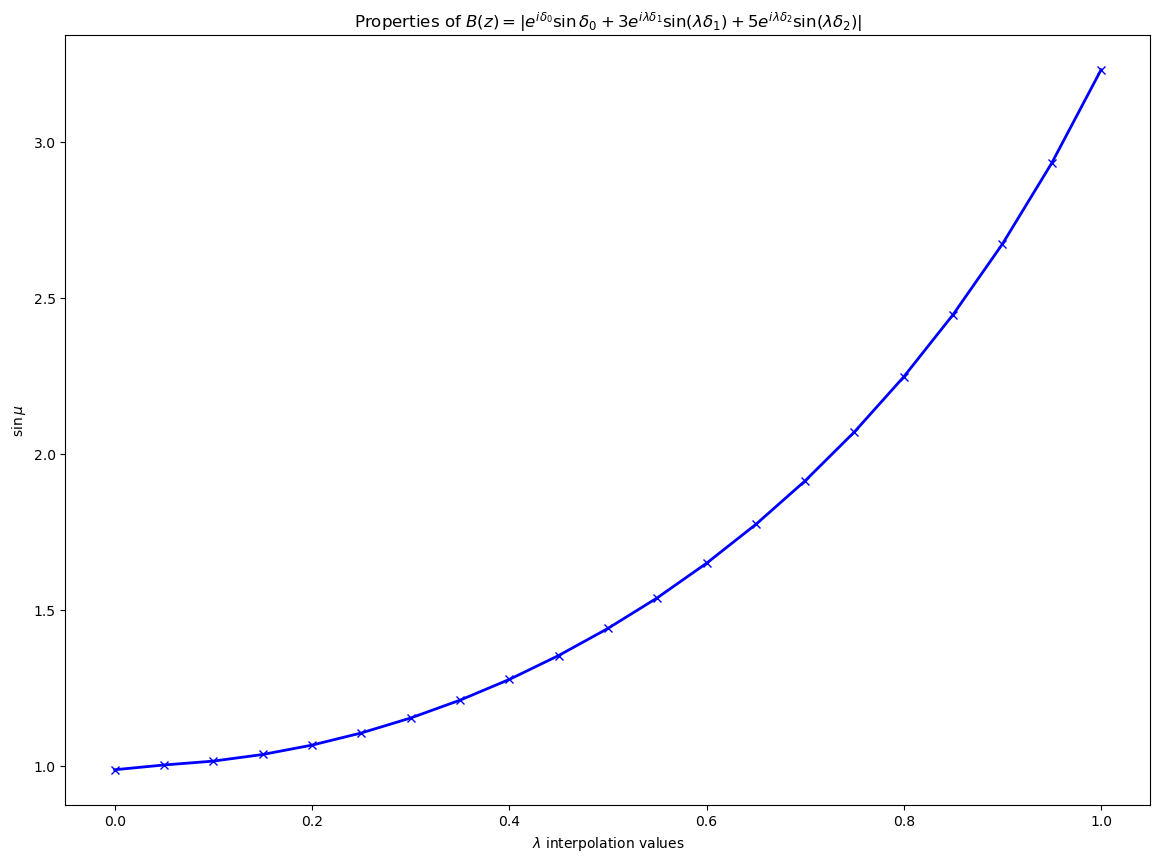

In [275]:
plt.figure(figsize=(14, 10))
plt.plot(lambda_list,sinmuvalues, 'b-x', linewidth = 2)  
plt.xlabel('$\lambda$ interpolation values')
plt.ylabel('$\sin \mu$')
plt.title('Properties of $B(z)=|e^{i \delta_0} \sin \delta_0 + 3 e^{i \lambda \delta_1} \sin(\lambda \delta_1) + 5 e^{i \lambda \delta_2} \sin(\lambda \delta_2)|$')
plt.show()

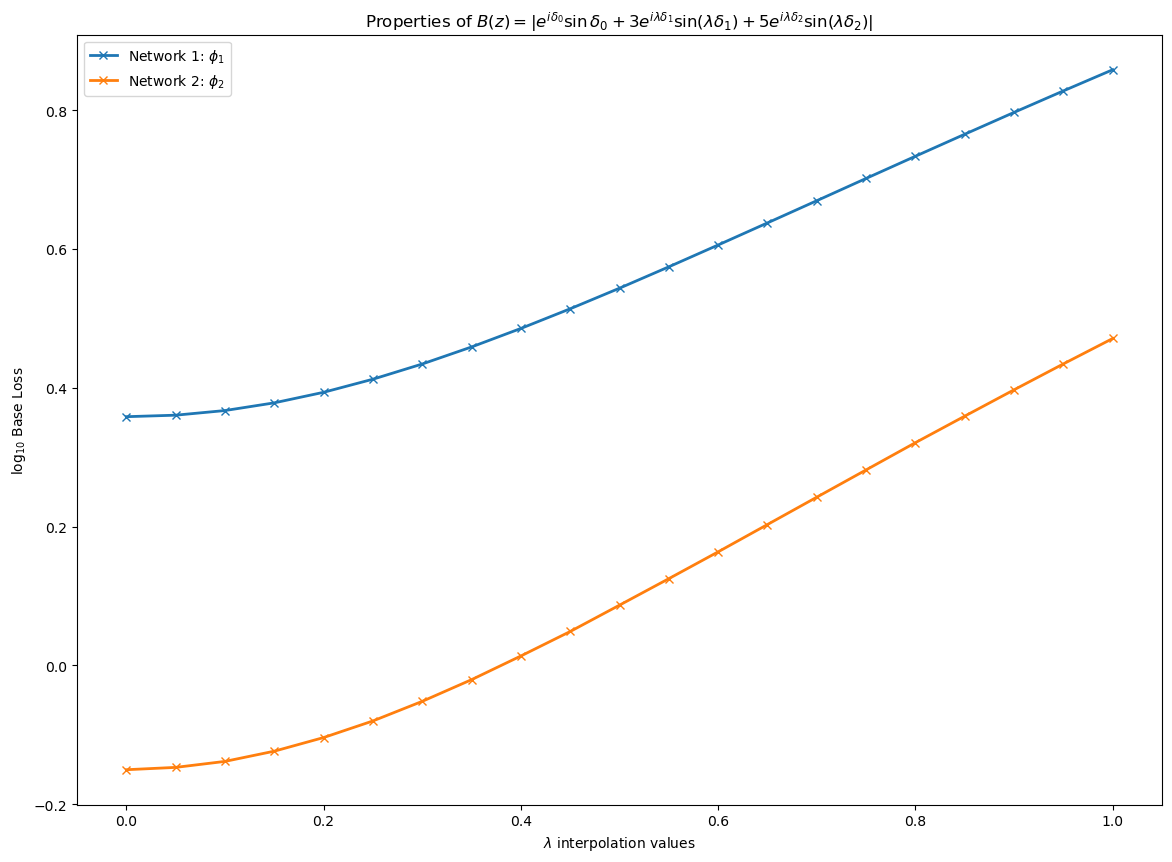

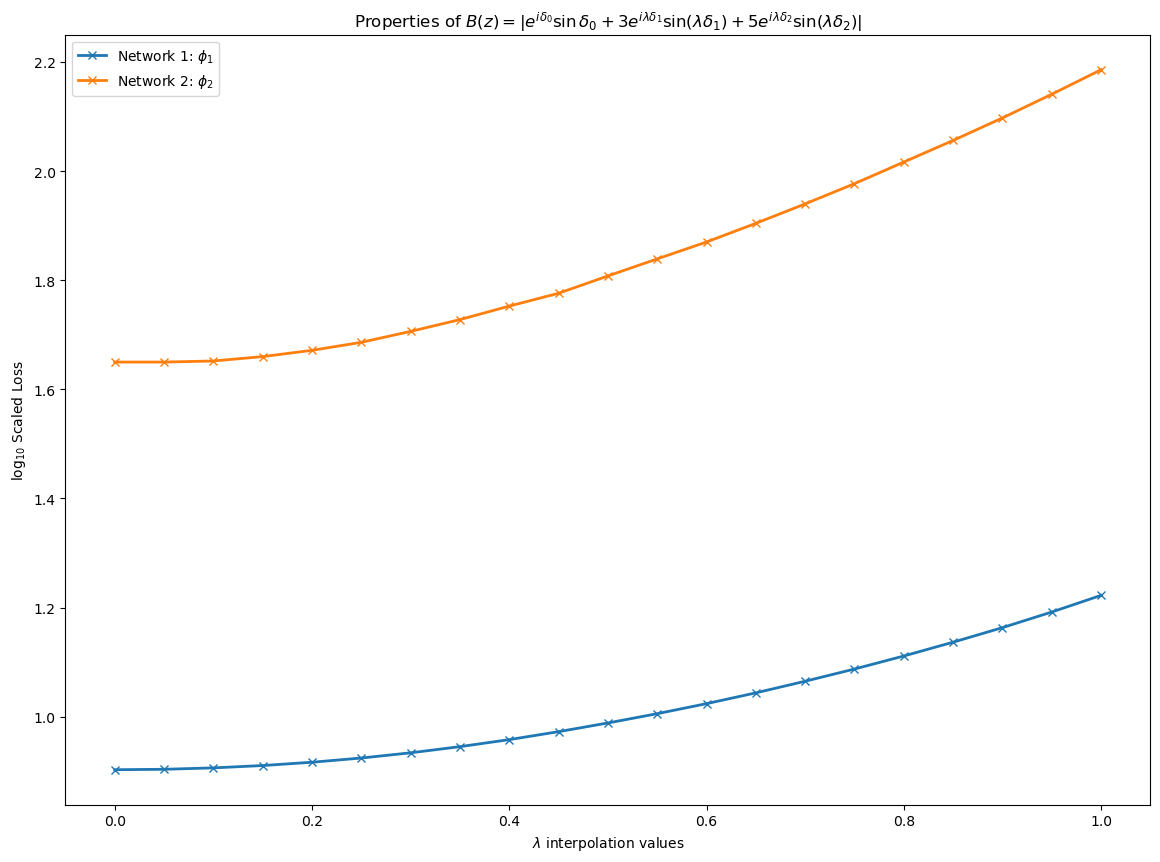

In [302]:
plt.figure(figsize=(14, 10))
nsl_loss_net_1 = [np.log10(nsl[0].cpu()) for nsl in non_scaled_losses]
nsl_loss_net_2 = [np.log10(nsl[1].cpu()) for nsl in non_scaled_losses]
plt.plot(lambda_list,nsl_loss_net_1, '-x', linewidth = 2)  
plt.plot(lambda_list,nsl_loss_net_2, '-x', linewidth = 2)  
plt.xlabel('$\lambda$ interpolation values')
plt.ylabel('$\log_{10}$ Base Loss')
plt.legend(['Network 1: $\phi_1$', 'Network 2: $\phi_2$'])
plt.title('Properties of $B(z)=|e^{i \delta_0} \sin \delta_0 + 3 e^{i \lambda \delta_1} \sin(\lambda \delta_1) + 5 e^{i \lambda \delta_2} \sin(\lambda \delta_2)|$')
plt.show()

plt.figure(figsize=(14, 10))
sl_loss_net_1 = [np.log10(sl[0].cpu()) for sl in scaled_losses]
sl_loss_net_2 = [np.log10(sl[1].cpu()) for sl in scaled_losses]
plt.plot(lambda_list,sl_loss_net_1, '-x', linewidth = 2)  
plt.plot(lambda_list,sl_loss_net_2, '-x', linewidth = 2)  
plt.xlabel('$\lambda$ interpolation values')
plt.ylabel('$\log_{10}$ Scaled Loss')
plt.legend(['Network 1: $\phi_1$', 'Network 2: $\phi_2$'])
plt.title('Properties of $B(z)=|e^{i \delta_0} \sin \delta_0 + 3 e^{i \lambda \delta_1} \sin(\lambda \delta_1) + 5 e^{i \lambda \delta_2} \sin(\lambda \delta_2)|$')
plt.show()

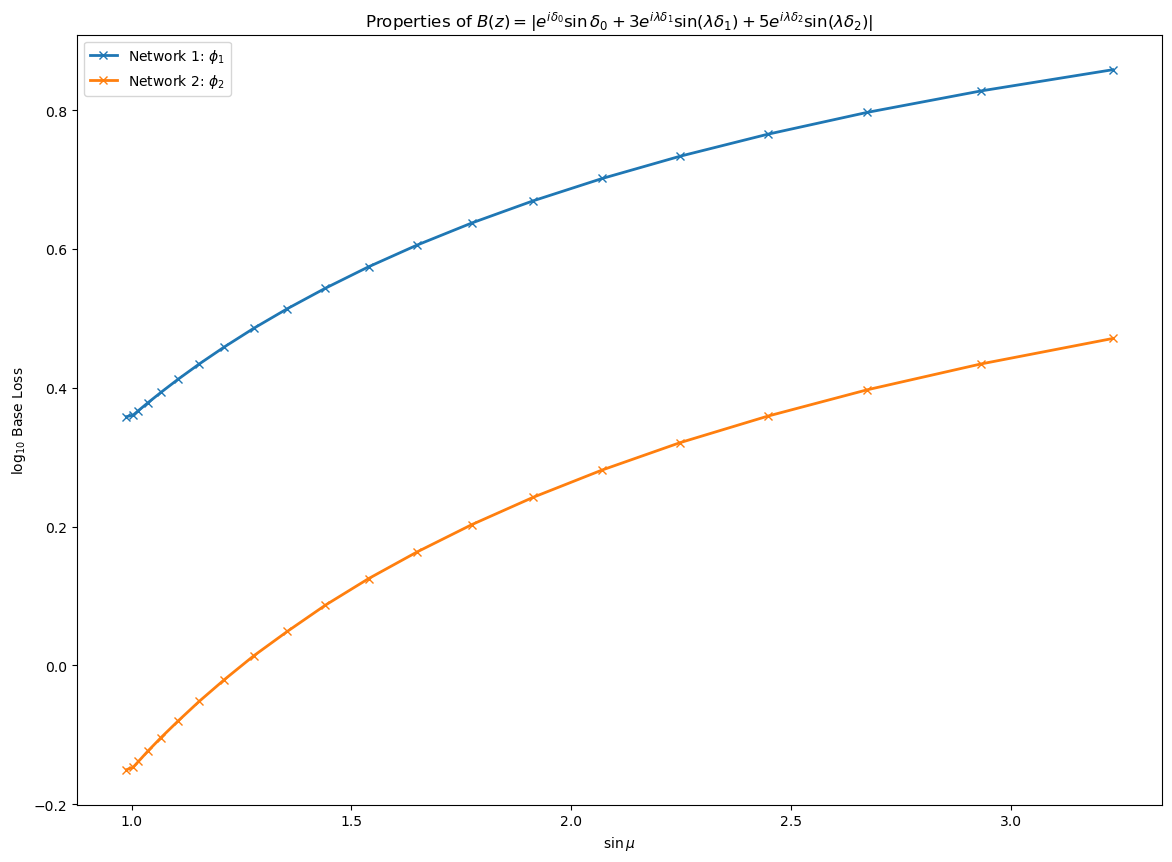

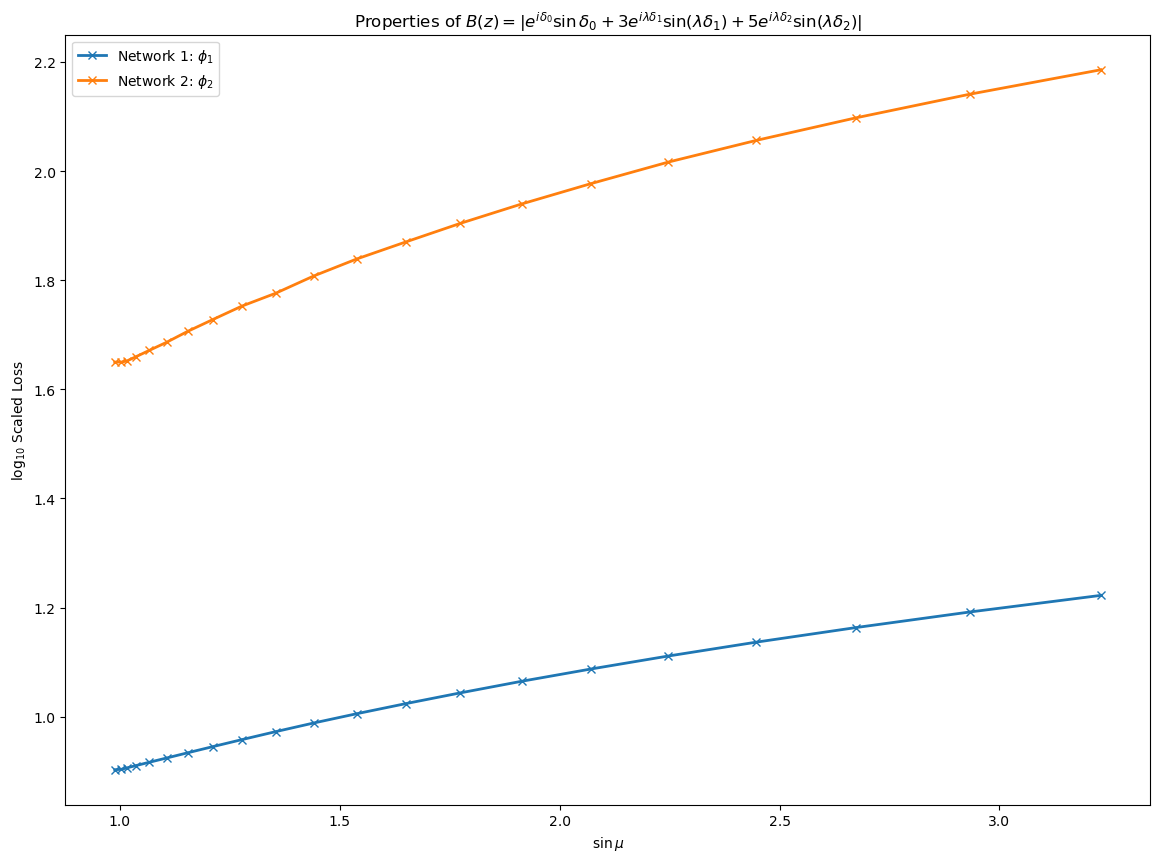

In [303]:
plt.figure(figsize=(14, 10))
nsl_loss_net_1 = [np.log10(nsl[0].cpu()) for nsl in non_scaled_losses]
nsl_loss_net_2 = [np.log10(nsl[1].cpu()) for nsl in non_scaled_losses]
plt.plot(sinmuvalues,nsl_loss_net_1, '-x', linewidth = 2)  
plt.plot(sinmuvalues,nsl_loss_net_2, '-x', linewidth = 2)  
plt.xlabel('$\sin \mu$')
plt.ylabel('$\log_{10}$ Base Loss')
plt.legend(['Network 1: $\phi_1$', 'Network 2: $\phi_2$'])
plt.title('Properties of $B(z)=|e^{i \delta_0} \sin \delta_0 + 3 e^{i \lambda \delta_1} \sin(\lambda \delta_1) + 5 e^{i \lambda \delta_2} \sin(\lambda \delta_2)|$')
plt.show()

plt.figure(figsize=(14, 10))
sl_loss_net_1 = [np.log10(sl[0].cpu()) for sl in scaled_losses]
sl_loss_net_2 = [np.log10(sl[1].cpu()) for sl in scaled_losses]
plt.plot(sinmuvalues, sl_loss_net_1, '-x', linewidth = 2)  
plt.plot(sinmuvalues, sl_loss_net_2, '-x', linewidth = 2)  
plt.xlabel('$\sin \mu$')
plt.ylabel('$\log_{10}$ Scaled Loss')
plt.legend(['Network 1: $\phi_1$', 'Network 2: $\phi_2$'])
plt.title('Properties of $B(z)=|e^{i \delta_0} \sin \delta_0 + 3 e^{i \lambda \delta_1} \sin(\lambda \delta_1) + 5 e^{i \lambda \delta_2} \sin(\lambda \delta_2)|$')
plt.show()

In [309]:
zpointseval

tensor([-1.0000, -0.9798, -0.9596, -0.9394, -0.9192, -0.8990, -0.8788, -0.8586,
        -0.8384, -0.8182, -0.7980, -0.7778, -0.7576, -0.7374, -0.7172, -0.6970,
        -0.6768, -0.6566, -0.6364, -0.6162, -0.5960, -0.5758, -0.5556, -0.5354,
        -0.5152, -0.4949, -0.4747, -0.4545, -0.4343, -0.4141, -0.3939, -0.3737,
        -0.3535, -0.3333, -0.3131, -0.2929, -0.2727, -0.2525, -0.2323, -0.2121,
        -0.1919, -0.1717, -0.1515, -0.1313, -0.1111, -0.0909, -0.0707, -0.0505,
        -0.0303, -0.0101,  0.0101,  0.0303,  0.0505,  0.0707,  0.0909,  0.1111,
         0.1313,  0.1515,  0.1717,  0.1919,  0.2121,  0.2323,  0.2525,  0.2727,
         0.2929,  0.3131,  0.3333,  0.3535,  0.3737,  0.3939,  0.4141,  0.4343,
         0.4545,  0.4747,  0.4949,  0.5152,  0.5354,  0.5556,  0.5758,  0.5960,
         0.6162,  0.6364,  0.6566,  0.6768,  0.6970,  0.7172,  0.7374,  0.7576,
         0.7778,  0.7980,  0.8182,  0.8384,  0.8586,  0.8788,  0.8990,  0.9192,
         0.9394,  0.9596,  0.9798,  1.00

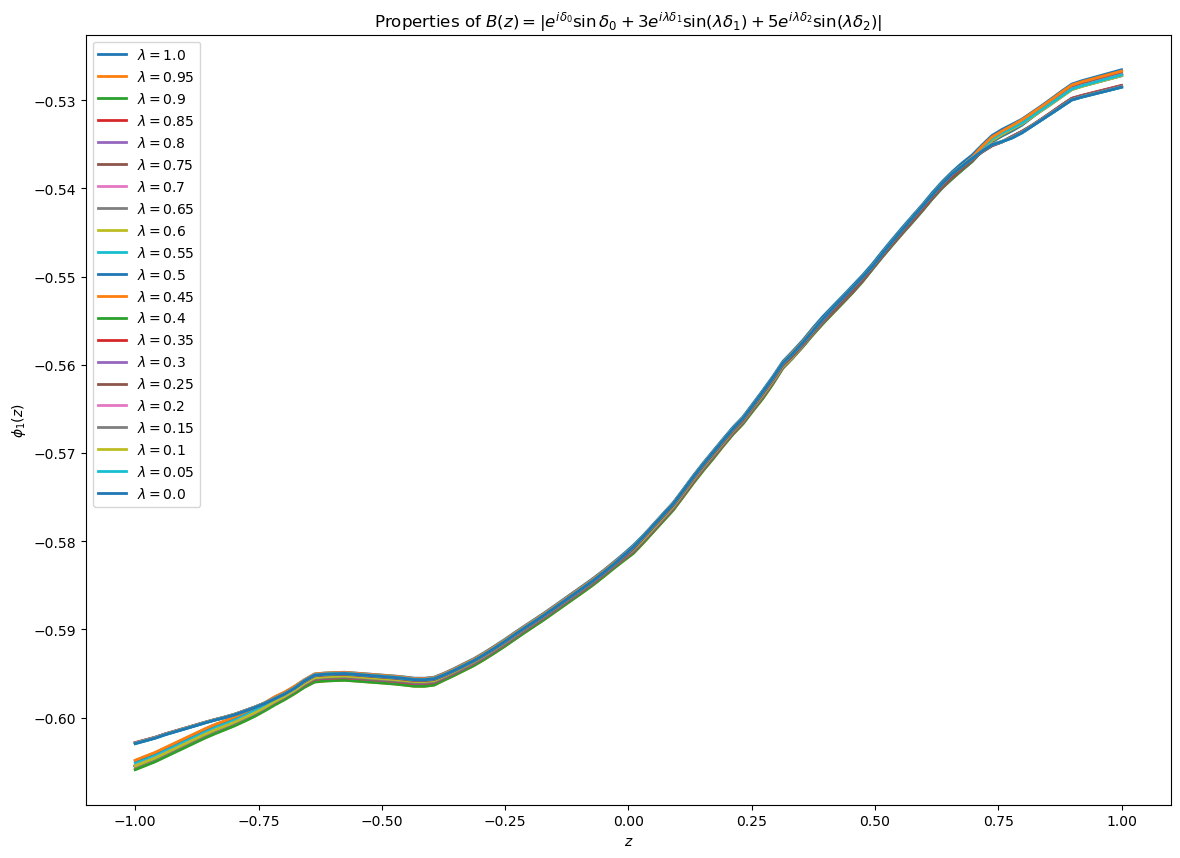

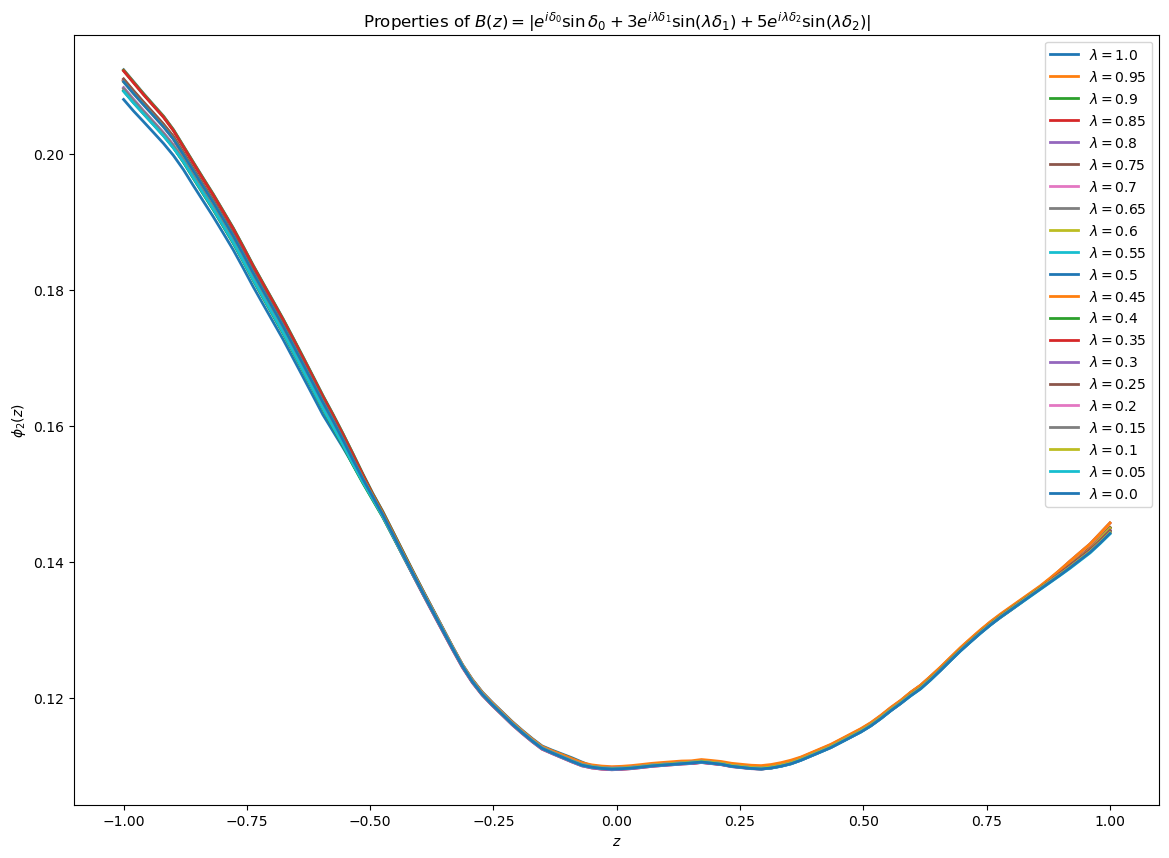

In [318]:
phase1 = [phases[0] for phases in solved_phases]
phase2 = [phases[1] for phases in solved_phases]


plt.figure(figsize=(14, 10))
legend_str = []

for i, lambda_val in enumerate(lambda_list):

    plt.plot(zpointseval.cpu(), phase1[i], '-', linewidth = 2)  
    legend_str.append('$\lambda = {}$'.format(round(lambda_val,2)))
    
plt.xlabel('$z$')
plt.ylabel('$\phi_1(z)$')
plt.legend(legend_str)
plt.title('Properties of $B(z)=|e^{i \delta_0} \sin \delta_0 + 3 e^{i \lambda \delta_1} \sin(\lambda \delta_1) + 5 e^{i \lambda \delta_2} \sin(\lambda \delta_2)|$')
plt.show()


plt.figure(figsize=(14, 10))
legend_str = []

for i, lambda_val in enumerate(lambda_list):

    plt.plot(zpointseval.cpu(), phase2[i], '-', linewidth = 2)  
    legend_str.append('$\lambda = {}$'.format(round(lambda_val,2)))
    
plt.xlabel('$z$')
plt.ylabel('$\phi_2(z)$')
plt.legend(legend_str)
plt.title('Properties of $B(z)=|e^{i \delta_0} \sin \delta_0 + 3 e^{i \lambda \delta_1} \sin(\lambda \delta_1) + 5 e^{i \lambda \delta_2} \sin(\lambda \delta_2)|$')
plt.show()